In [1]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import linear_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np
import seaborn as sns
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman2
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
import itertools
import pmdarima as pm
from sklearn.pipeline import make_pipeline
from pmdarima.arima import auto_arima
from sklearn.kernel_ridge import KernelRidge		
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from pmdarima.model_selection import train_test_split
from evds import evdsAPI
import pandas as pd
import numpy as np
from arch import arch_model
warnings.filterwarnings("ignore")

In [2]:
evds=evdsAPI('dsIC3fiGlu')


In [3]:
import yfinance as yf 


In [4]:
usd=evds.get_data(["TP.DK.USD.S.YTL"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
usd.dropna(inplace=True)
usd.iloc[-1,1]=yf.download(tickers='USDTRY=X',interval='1m')["Adj Close"][-1]
usd

[*********************100%%**********************]  1 of 1 completed


,Tarih,TP_DK_USD_S_YTL
0,01-02-2006,1.326300
1,02-02-2006,1.324100
2,03-02-2006,1.327700
3,06-02-2006,1.325700
4,07-02-2006,1.329600
...,...,...
4684,16-01-2024,30.099000
4685,17-01-2024,30.101100
4686,18-01-2024,30.126300
4687,19-01-2024,30.138900


In [5]:
usd['Tarih'] = pd.to_datetime(usd['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
usd.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
usd = usd.resample('M').mean()

usd

,TP_DK_USD_S_YTL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-09-30,26.989448
2023-10-31,27.846114
2023-11-30,28.637082


In [6]:
enf=evds.get_data(["TP.FE.OKTG01"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"))
enf

,Tarih,TP_FE_OKTG01
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
210,2023-8,1614.31
211,2023-9,1691.04
212,2023-10,1749.11
213,2023-11,1806.50


In [7]:

enf=pd.DataFrame(enf)
enf.columns=["Tarih","TÜFE"]


In [8]:

inflation=enf
inflation

,Tarih,TÜFE
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
210,2023-8,1614.31
211,2023-9,1691.04
212,2023-10,1749.11
213,2023-11,1806.50


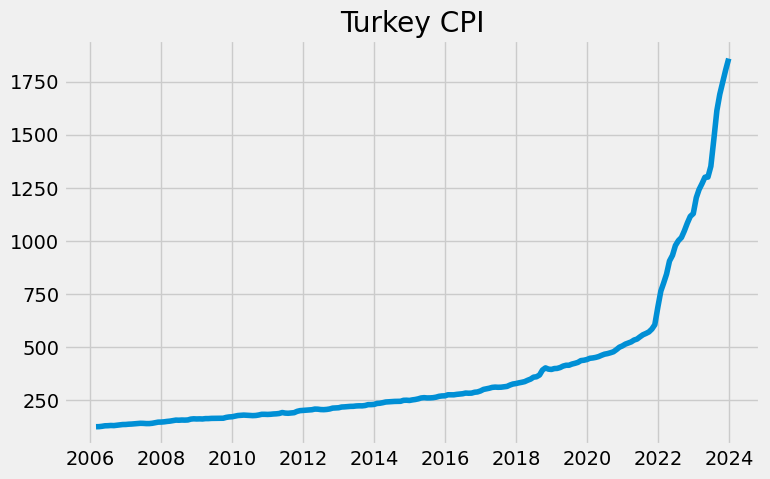

In [9]:
dates=pd.date_range(start="2006-02-28",periods=len(enf) , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)
plt.figure(figsize=(8,5))
plt.title("Turkey CPI")
plt.plot(df)
plt.show()


In [10]:
df6=pd.DataFrame()
df6["USD/TL"]=usd["TP_DK_USD_S_YTL"]

df6["USD/TL"]=df6["USD/TL"].astype(float)
df6

,USD/TL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-09-30,26.989448
2023-10-31,27.846114
2023-11-30,28.637082


In [11]:
money=evds.get_data(["TP.PR.ARZ13"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del money["Tarih"]
money=pd.DataFrame(money)
money.columns=["Para Arzi"]
money=money.set_index(pd.date_range('2006-02-28',periods=len(money), freq='1M'))
money

,Para Arzi
2006-02-28,2.423895e+08
2006-03-31,2.494857e+08
2006-04-30,2.521919e+08
2006-05-31,2.751947e+08
2006-06-30,2.791388e+08
...,...
2023-09-30,1.234931e+10
2023-10-31,1.276379e+10
2023-11-30,1.305046e+10
2023-12-31,1.361599e+10


In [12]:
m3=evds.get_data(["TP.PR.ARZ22"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del m3["Tarih"]
m3.columns=["M3 Para Arzi"]
m3=m3/1e+08
m3=m3.set_index(money.index)
m3

,M3 Para Arzi
2006-02-28,2.663248
2006-03-31,2.731552
2006-04-30,2.767716
2006-05-31,3.025340
2006-06-30,3.038097
...,...
2023-09-30,126.661059
2023-10-31,130.934676
2023-11-30,134.161244
2023-12-31,140.183543


In [13]:

issizlik=evds.get_data(["TP.TIG08"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del issizlik["Tarih"]
issizlik.columns=["İşsizlik"]
issizlik=issizlik.dropna(axis=0)
issizlik=issizlik.set_index(pd.date_range(start="2014-01-30",periods=len(issizlik),freq="1M"))
issizlik

,İşsizlik
2014-01-31,9.2
2014-02-28,9.5
2014-03-31,9.5
2014-04-30,9.7
2014-05-31,9.7
...,...
2023-07-31,9.3
2023-08-31,9.1
2023-09-30,9.0
2023-10-31,8.5


In [14]:
import yfinance as yf
df14=yf.download("BZ=F")["Close"]
df14=pd.DataFrame(df14)
df14.columns=["Brent"]
df14=df14.resample('M').mean()
df14

[*********************100%%**********************]  1 of 1 completed


,Brent
Date,
2007-07-31,76.395000
2007-08-31,71.258696
2007-09-30,77.135263
2007-10-31,82.456957
2007-11-30,92.060953
...,...
2023-09-30,92.766499
2023-10-31,88.704091
2023-11-30,82.027727


In [15]:
kredi=evds.get_data(["TP.KREDI.L001"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=1)
del kredi["Tarih"]
del kredi["YEARWEEK"]
kredi=kredi.set_index(pd.date_range(start="2006-02-03",periods=len(kredi),freq="W"))
kredi.columns=["Kredi"]
kredi=(kredi.pct_change(4)*100).dropna()
kredi=kredi.resample('M').last()
kredi

,Kredi
2006-03-31,4.327119
2006-04-30,3.124932
2006-05-31,8.993162
2006-06-30,3.364474
2006-07-31,-0.493205
...,...
2023-09-30,2.412238
2023-10-31,2.154973
2023-11-30,2.932091
2023-12-31,2.873464


In [16]:
df3=pd.DataFrame()
df3["Kredi"]=kredi["Kredi"]
df3["TIME"]=pd.date_range(start="2006-03-28",periods=len(df3),freq="1M")
df3['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df3 = df3.set_index(['TIME'])
df3=df3.set_index(pd.date_range('2006-03-28',periods=len(df3) , freq='1M'))
df3

,Kredi
2006-03-31,4.327119
2006-04-30,3.124932
2006-05-31,8.993162
2006-06-30,3.364474
2006-07-31,-0.493205
...,...
2023-09-30,2.412238
2023-10-31,2.154973
2023-11-30,2.932091
2023-12-31,2.873464


In [17]:
pfaiz=evds.get_data(["TP.APIFON4"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
pfaiz.columns=["Tarih","Faiz"]
pfaiz.iloc[:11,1]=17.5
pfaiz.iloc[11:23,1]=21.5
pfaiz.iloc[23:35,1]=19.25
pfaiz.iloc[35:47,1]=10.25
pfaiz.iloc[47:59,1]=8
pfaiz["Faiz"]=pfaiz["Faiz"].astype(float)
#pfaiz.iloc[212,1]=35
pfaiz



,Tarih,Faiz
0,2006-2,17.50
1,2006-3,17.50
2,2006-4,17.50
3,2006-5,17.50
4,2006-6,17.50
...,...,...
211,2023-9,31.00
212,2023-10,33.00
213,2023-11,41.09
214,2023-12,42.50


In [18]:
dates=pd.date_range('2006-02-28',periods=len(pfaiz) , freq='1M')
pfaiz=pd.DataFrame(pfaiz)
pfaiz.columns=["Tarih","Politika Faizi"]
pfaiz["TIME"]=dates
pfaiz['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
pfaiz = pfaiz.set_index(['TIME'])
del pfaiz["Tarih"]
pfaiz

,Politika Faizi
TIME,
2006-02-28,17.50
2006-03-31,17.50
2006-04-30,17.50
2006-05-31,17.50
2006-06-30,17.50
...,...
2023-09-30,31.00
2023-10-31,33.00
2023-11-30,41.09


In [19]:
kfaiz=evds.get_data(["TP.KTFTUK"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
del kfaiz["Tarih"]
del kfaiz["YEARWEEK"]
kfaiz=kfaiz.set_index(pd.date_range(start="2006-02-01",periods=len(kfaiz),freq="1W"))
kfaiz=kfaiz.resample('M').apply(lambda x : x[-2:].iloc[-1])
kfaiz.columns=["Kredi Faizi"]
kfaiz

,Kredi Faizi
2006-02-28,17.02
2006-03-31,16.88
2006-04-30,15.84
2006-05-31,16.60
2006-06-30,20.35
...,...
2023-09-30,57.56
2023-10-31,58.43
2023-11-30,58.61
2023-12-31,58.16


In [20]:
perakende=pd.read_excel("./perakende satis hacim endeksi ve degisim oranlari (sabit fiyatlarla) (2015=100).xls")
perakende1=perakende.iloc[5:,2].dropna(axis=0).astype(float)
perakende1=pd.DataFrame(perakende1)
perakende1.columns=["Arındırılmamış"]


perakende1["Takvimden Arındırılmış"]=perakende.iloc[5:,4].astype(float)
perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]=perakende.iloc[5:,7].astype(float)
perakende1=perakende1.set_index(pd.date_range(start="2010-01-01",periods=len(perakende1),freq="1M"))
perakende1

,Arındırılmamış,Takvimden Arındırılmış,Mevsimsellikten ve Takvimden Arındırılmış
2010-01-31,57.403841,57.747949,67.560585
2010-02-28,57.317027,57.179176,68.192727
2010-03-31,67.904361,67.034985,69.536955
2010-04-30,67.048510,66.458455,70.175625
2010-05-31,70.327428,70.614865,70.604236
...,...,...,...
2023-06-30,180.070938,186.192371,179.437348
2023-07-31,191.652101,194.142558,184.796934
2023-08-31,185.107822,183.341634,176.289202
2023-09-30,184.891859,183.368030,175.221191


In [21]:
motorin=pd.read_excel("./motorin.xlsx")
motorin.columns=["Tarih","Motorin"]
motorin=motorin.set_index(pd.date_range(start="2003-01-01",periods=len(motorin),freq="1M"))
del motorin["Tarih"]
motorin=motorin.astype(float)
motorin

,Motorin
2003-01-31,1.366645
2003-02-28,1.457199
2003-03-31,1.529555
2003-04-30,1.439813
2003-05-31,1.404363
...,...
2023-09-30,39.180000
2023-10-31,38.900000
2023-11-30,37.680000
2023-12-31,36.420000


In [22]:
sanayi=pd.read_excel("./sanayi uretim endeksi ve degisim oranlari (2015=100).xls")
sanayi=pd.DataFrame(sanayi.iloc[8:,5])
sanayi.columns=["Sanayi"]
sanayi=sanayi.set_index(pd.date_range(start="2005-02-08",periods=len(sanayi),freq="1M"))
sanayi=sanayi.dropna()
sanayi=sanayi.astype(float)
sanayi

,Sanayi
2005-02-28,57.747916
2005-03-31,57.058754
2005-04-30,57.685141
2005-05-31,58.226534
2005-06-30,58.022939
...,...
2023-07-31,147.426310
2023-08-31,146.188629
2023-09-30,146.015076
2023-10-31,145.634666


In [23]:
mfaiz=evds.get_data(["TP.TRY.MT02"],startdate="03-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
#mfaiz=mfaiz.set_index(pd.date_range(start="2006-02-01",end="2024-01-01",freq="1M"))
del mfaiz["YEARWEEK"]
del mfaiz["Tarih"]
mfaiz=mfaiz.set_index(pd.date_range(start="2006-02-03",periods=len(mfaiz),freq="W"))
mfaiz=mfaiz.resample('M').apply(lambda x : x[-2:].iloc[-1])

mfaiz.columns=["Mevduat Faizi"]
mfaiz

,Mevduat Faizi
2006-02-28,15.70
2006-03-31,14.84
2006-04-30,14.87
2006-05-31,14.84
2006-06-30,15.57
...,...
2023-09-30,42.74
2023-10-31,41.72
2023-11-30,46.07
2023-12-31,52.50


In [24]:
from datetime import date
enf_belirsizlik=evds.get_data(["TP.BEK.S01.E.S"],startdate="30-06-2013",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
enf_belirsizlik=enf_belirsizlik.set_index(pd.date_range(start="2013-06-30",periods=len(enf_belirsizlik),freq="1M"))
del enf_belirsizlik["Tarih"]
enf_belirsizlik.columns=["Enflasyon Belirsizliği"]
enf_belirsizlik

,Enflasyon Belirsizliği
2013-06-30,0.62
2013-07-31,0.74
2013-08-31,0.74
2013-09-30,0.77
2013-10-31,0.65
...,...
2023-09-30,7.30
2023-10-31,5.57
2023-11-30,4.49
2023-12-31,3.36


In [25]:
borc=evds.get_data(["TP.KB.A09"],startdate="01-01-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del borc["Tarih"]
borc=borc.set_index(pd.date_range(start="2006-01-01",periods=len(borc),freq="1M"))
borc.columns=["Borç"]
borc

,Borç
2006-01-31,2.435600e+08
2006-02-28,2.464270e+08
2006-03-31,2.463600e+08
2006-04-30,2.466640e+08
2006-05-31,2.507320e+08
...,...
2023-07-31,2.643068e+09
2023-08-31,2.758965e+09
2023-09-30,2.859751e+09
2023-10-31,2.966763e+09


In [26]:
redk=evds.get_data(["TP.RK.U01.Y"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del redk["Tarih"]
redk=redk.set_index(pd.date_range(start="2011-03-30",periods=len(redk),freq="1M"))
redk.columns=["REDK"]
redk

,REDK
2011-03-31,105.42
2011-04-30,107.10
2011-05-31,103.79
2011-06-30,101.84
2011-07-31,98.49
...,...
2023-08-31,85.33
2023-09-30,89.20
2023-10-31,89.14
2023-11-30,87.40


In [27]:
redkt=evds.get_data(["TP.RK.T1.Y"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del redkt["Tarih"]
redkt=redkt.set_index(pd.date_range(start="2011-03-30",periods=len(redkt),freq="1M"))
redkt.columns=["REDKT"]
redkt

,REDKT
2011-03-31,111.62
2011-04-30,114.17
2011-05-31,112.89
2011-06-30,108.98
2011-07-31,104.82
...,...
2023-08-31,52.40
2023-09-30,55.53
2023-10-31,56.04
2023-11-30,55.25


In [28]:
data=pd.DataFrame()
data["USD/TL"]=df6["USD/TL"].rolling(3).mean()
#data["USD/TL2"]=df6["USD/TL"]
#data["USD/TL3"]=df6["USD/TL"]**2
#data["USD/TL4"]=df6["USD/TL"]**3
#data["USD/TL5"]=df6["USD/TL"].shift(1)
data["ParaArzi"]=money["Para Arzi"].shift(1)
data["Motorin"]=motorin["Motorin"]
data["Perakende Satış"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]
data["Sanayi"]=sanayi["Sanayi"]
data["M3"]=m3["M3 Para Arzi"].shift(1)
data["Borç"]=(borc["Borç"]).shift(1)
data["TÜFE"]=df["CPI"]
data=data.pct_change()*100
data

,USD/TL,ParaArzi,Motorin,Perakende Satış,Sanayi,M3,Borç,TÜFE
Tarih,,,,,,,,
2006-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-31,NaN,NaN,0.975610,NaN,2.437308,NaN,1.177123,0.274548
2006-04-30,NaN,2.927613,2.898551,NaN,-0.738864,2.564688,-0.027189,1.336769
2006-05-31,2.353679,1.084694,4.694836,NaN,0.882710,1.323922,0.123397,1.875397
2006-06-30,6.483947,9.121170,5.829596,NaN,0.536906,9.308200,1.649207,0.335413
...,...,...,...,...,...,...,...,...
2023-09-30,5.071342,4.764088,4.843457,-0.605829,-0.118719,4.845313,4.384930,4.753114
2023-10-31,1.709911,2.694232,-0.714650,1.976717,-0.260527,2.614384,3.653039,3.433981
2023-11-30,2.001541,3.356297,-3.136247,0.000000,-1.421973,3.374057,3.741984,3.281097


In [29]:

data["Kredi"]=df3["Kredi"].rolling(3).mean()
data["İşsizlik"]=issizlik["İşsizlik"]
data["Enflasyon Belirsizliği"]=enf_belirsizlik
data["Kredi Faizi"]=kfaiz["Kredi Faizi"]
data["Mevduat Faizi"]=mfaiz["Mevduat Faizi"]
data["Politika Faizi"]=pfaiz["Politika Faizi"]
data["Zam"]=0
data["REDK"]=redk["REDK"]
data["REDKT"]=redkt["REDKT"]
data=data[['USD/TL', 'Motorin', 'Perakende Satış', 'Kredi Faizi','Zam', 'Sanayi', 'Enflasyon Belirsizliği','ParaArzi','Borç','Kredi','Mevduat Faizi','REDK','REDKT','İşsizlik','Politika Faizi','TÜFE']]
data.iloc[11:23,4]=12.3
data.iloc[23:35,4]=29.32
data.iloc[35:47,4]=7.92
data.iloc[47:59,4]=14.17
data.iloc[59:71,4]=25.45
data.iloc[71:83,4]=15
data.iloc[83:95,4]=8
data.iloc[95:107,4]=846
data.iloc[107:119,4]=949.07
data.iloc[119:131,4]=1300.99
data.iloc[131:143,4]=1404.6
data.iloc[143:155,4]=1603.12
data.iloc[155:167,4]=2020.59
data.iloc[167:179,4]=2324.70
data.iloc[179:191,4]=2825.90
data.iloc[191:197,4]=4253.40
data.iloc[197:203,4]=5500.35
data.iloc[203:209,4]=8506.80
data.iloc[209:,4]=11402.32
data["Zam"]=data["Zam"].pct_change()*100
data=data.fillna(0)
data=data.loc["2014-01-31":"2023-12-31"]
data.iloc[0,4]=14.2
data

,USD/TL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDK,REDKT,İşsizlik,Politika Faizi,TÜFE
Tarih,,,,,,,,,,,,,,,,
2014-01-31,3.732429,2.881984,3.944616,13.80,14.2,3.604096,0.82,3.375162,-0.584687,2.669930,8.85,91.32,95.75,9.2,9.96,1.978080
2014-02-28,3.033477,1.685899,-4.487196,15.54,0.0,-0.850238,0.73,1.804994,0.808574,1.876850,10.75,93.31,96.63,9.5,10.23,0.428192
2014-03-31,2.465778,-2.278097,-0.070420,16.05,0.0,0.128936,0.80,0.451349,0.193691,0.822203,11.65,93.75,97.25,9.5,10.27,1.125608
2014-04-30,-1.344724,-6.214384,-0.769499,15.65,0.0,-0.863760,0.73,0.796760,0.478162,-0.154556,10.75,98.14,102.98,9.7,10.03,1.344970
2014-05-31,-1.859714,-0.561578,0.433585,15.36,0.0,-1.367417,0.80,-0.362357,0.091080,0.146305,10.43,99.40,105.10,9.7,9.53,0.395224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,10.505114,26.763908,-4.603827,45.29,0.0,-0.839525,6.81,5.943431,2.618269,3.836917,30.76,85.33,52.40,9.1,23.50,9.086793
2023-09-30,5.071342,4.843457,-0.605829,57.56,0.0,-0.118719,7.30,4.764088,4.384930,2.048237,42.74,89.20,55.53,9.0,31.00,4.753114
2023-10-31,1.709911,-0.714650,1.976717,58.43,0.0,-0.260527,5.57,2.694232,3.653039,1.782758,41.72,89.14,56.04,8.5,33.00,3.433981


<Axes: title={'center': 'TÜFE ile Korelasyonlar'}>

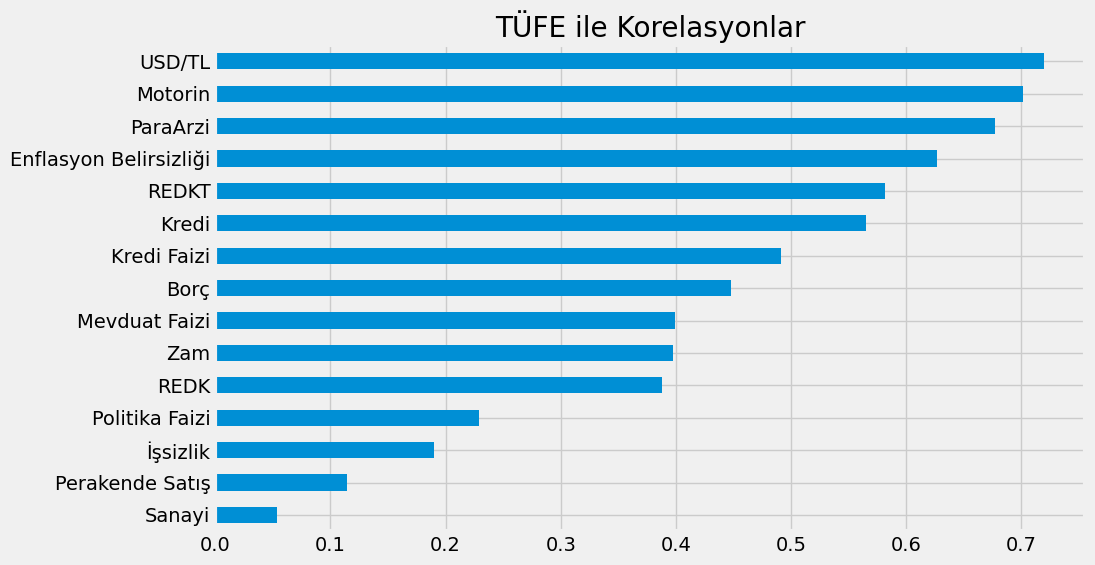

In [30]:
cor_matrix=data.corr()
cor_matrix=abs(cor_matrix["TÜFE"]).sort_values(ascending=True)
cor_matrix[:-1].plot(kind="barh",title="TÜFE ile Korelasyonlar",figsize=(10,6))

In [31]:
data=data.drop(["Perakende Satış","Sanayi"],axis=1)

In [32]:
model=auto_arima(pfaiz["Politika Faizi"],seasonal=False,information_criterion="bic")
model_fit = model.fit(pfaiz["Politika Faizi"])
faiztahmin = model_fit.predict(25)
faiztahmin=pd.DataFrame(faiztahmin)
faiztahmin.columns=["Politika Faizi"]
row=pd.DataFrame({"Politika Faizi":pfaiz.iloc[210:,0]},index=pd.date_range(start="2023-08-30",end="2024-02-28",freq="1M"))
faiztahmin=pd.concat([row,faiztahmin],axis=0)
faiztahmin.iloc[4:,0]=[42.5,45,45,45,45,45,45,45,45,45,42.5,40,37.5,35,35,35,35,35,35,35,32.5,30,27.5,25,25,25,25]
faiztahmin

,Politika Faizi
2023-08-31,23.50
2023-09-30,31.00
2023-10-31,33.00
2023-11-30,41.09
2023-12-31,42.50
2024-01-31,45.00
2024-02-29,45.00
2024-03-31,45.00
2024-04-30,45.00
2024-05-31,45.00


In [33]:
model=auto_arima(kfaiz["Kredi Faizi"],seasonal=True,X=np.array(pfaiz["Politika Faizi"]).reshape(-1,1),information_criterion="aic",m=9)
model_fit = model.fit(kfaiz["Kredi Faizi"])

forecast = model_fit.predict(25,X=np.array(faiztahmin["Politika Faizi"][6:]).reshape(-1,1))
kfaiztahmin=pd.DataFrame(forecast)
kfaiztahmin.columns=["Kredi Faizi"]
new_row=pd.DataFrame({"Kredi Faizi":kfaiz.iloc[210:,0]},index=pd.date_range(start="2023-08-30",end="2024-02-28",freq="1M"))
kfaiztahmin=pd.concat([new_row,kfaiztahmin],axis=0)
kfaiztahmin



,Kredi Faizi
2023-08-31,45.290000
2023-09-30,57.560000
2023-10-31,58.430000
2023-11-30,58.610000
2023-12-31,58.160000
2024-01-31,62.090000
2024-02-29,63.452698
2024-03-31,63.925203
2024-04-30,64.089041
2024-05-31,64.145850


In [34]:
trainexog=kfaiz[47:-2]
trainexog

,Kredi Faizi
2010-01-31,13.76
2010-02-28,13.36
2010-03-31,13.10
2010-04-30,13.18
2010-05-31,13.25
...,...
2023-07-31,44.58
2023-08-31,45.29
2023-09-30,57.56
2023-10-31,58.43


In [35]:
testexog=kfaiztahmin[2:]
testexog

,Kredi Faizi
2023-10-31,58.430000
2023-11-30,58.610000
2023-12-31,58.160000
2024-01-31,62.090000
2024-02-29,63.452698
2024-03-31,63.925203
2024-04-30,64.089041
2024-05-31,64.145850
2024-06-30,64.165548
2024-07-31,64.172379


In [36]:
faiztahmin[5:]

,Politika Faizi
2024-01-31,45.0
2024-02-29,45.0
2024-03-31,45.0
2024-04-30,45.0
2024-05-31,45.0
2024-06-30,45.0
2024-07-31,45.0
2024-08-31,45.0
2024-09-30,45.0
2024-10-31,42.5


In [37]:
model=auto_arima(mfaiz["Mevduat Faizi"],X=pfaiz,trace=False,seasonal=False,information_criterion="aic")
mfaiztahmin=pd.DataFrame(model.predict(27,X=faiztahmin[4:]))
mfaiztahmin.columns=["Mevduat Faizi"]
row=pd.DataFrame({"Mevduat Faizi":mfaiz.iloc[-2:,0]},index=pd.date_range(start="2023-12-30",periods=2,freq="1M"))
mfaiztahmin=pd.concat([row,mfaiztahmin],axis=0)
mfaiztahmin


,Mevduat Faizi
2023-12-31,52.500000
2024-01-31,51.050000
2024-02-29,49.225889
2024-03-31,52.137858
2024-04-30,52.034307
2024-05-31,51.398983
2024-06-30,51.790521
2024-07-31,51.848331
2024-08-31,51.649227
2024-09-30,51.733315


In [38]:
trainexog=pd.DataFrame()
trainexog["Dolar"]=usd.iloc[-16:-6,0].rolling(2).mean().dropna()*df14.iloc[:-6,0]
trainexog=trainexog.dropna()
trainexog=np.array(trainexog).reshape(-1,1)
testexog=pd.DataFrame()
testexog["Dolar"]=usd.iloc[-7:,0].rolling(2).mean().dropna()*df14.iloc[-6:,0]
testexog=testexog.dropna()
testexog=np.array(testexog).reshape(-1,1)

In [39]:
exog=pd.DataFrame()
exog["X"]=usd["TP_DK_USD_S_YTL"].rolling(2).mean().dropna()*df14["Brent"]
exog=exog.dropna()
exog
#exog=np.array(exog).reshape(-1,1)


,X
2007-07-31,99.454046
2007-08-31,92.519699
2007-09-30,99.580871
2007-10-31,101.824103
2007-11-30,110.143119
...,...
2023-09-30,2504.165548
2023-10-31,2432.069312
2023-11-30,2316.594077
2023-12-31,2231.258978


In [40]:

zamtahmin=pd.DataFrame()
zamtahmin["Zam"]=[0,0,0,0,0,49.11,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,25]
zamtahmin.columns=["Zam"]
zamtahmin=zamtahmin.set_index(pd.date_range(start="2023-08-30",end="2026-02-27",freq="1M"))
zamtahmin

,Zam
2023-08-31,0.00
2023-09-30,0.00
2023-10-31,0.00
2023-11-30,0.00
2023-12-31,0.00
2024-01-31,49.11
2024-02-29,0.00
2024-03-31,0.00
2024-04-30,0.00
2024-05-31,0.00


In [41]:
faiztahmin.columns=["Faiz"]


In [42]:
exogtrain=pd.DataFrame()
exogtrain["Faiz"]=pfaiz["Politika Faizi"].iloc[95:-14]
exogtrain=np.array(exogtrain).reshape(-1,1)

exogtest=pd.DataFrame()
exogtest=pd.concat([pfaiz["Politika Faizi"].iloc[-14:-2],faiztahmin.iloc[2:,0]],axis=0)
exogtest=np.array(exogtest).reshape(-1,1)



In [43]:
exog=pfaiz["Politika Faizi"].iloc[95:-2]
exog=np.array(exog).reshape(-1,1)

In [44]:
exogtest=faiztahmin.iloc[3:]
exogtest=np.array(exogtest).reshape(-1,1)

In [45]:
model=auto_arima(issizlik,seasonal=True,m=3,X=exog)
model_fit = model.fit(issizlik,X=exog)
issizliktahmin = model_fit.predict(28,X=exogtest)
issizliktahmin=pd.DataFrame(issizliktahmin)
issizliktahmin.columns=["İşsizlik"]
issizliktahmin

,İşsizlik
2023-12-31,9.038680
2024-01-31,8.940522
2024-02-29,9.141120
2024-03-31,9.201787
2024-04-30,9.221023
2024-05-31,9.328421
2024-06-30,9.388207
2024-07-31,9.433416
2024-08-31,9.502816
2024-09-30,9.556027


In [46]:
from prophet import Prophet


In [71]:
df6.shape

(216, 1)

In [72]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.01, 20),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df6.index
    sn["y"]=df6.values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth='linear',seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"])
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=14,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-14])
    return mae_score
try:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=2000)
    print("Optimize işlemi başarıyla tamamlandı.")
except Exception as e:
    print(f'Hata oluştu: {e}')
    print('Optimize işlemi başarısız oldu. Devam ediyor...')
"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.01, 20),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.001,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df6.index\n    sn["y"]=df6.values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=\'linear\',seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"])\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=14,freq="M")\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_sco

In [73]:
"""study.best_params"""

'study.best_params'

In [47]:
sn=pd.DataFrame()
sn["ds"]=df6.index
sn["y"]=df6.values
prophet=Prophet(growth="linear",changepoint_prior_scale=7.495807516055437,changepoint_range=0.9731904611246964,seasonality_prior_scale=7.717380426245633,n_changepoints=90,interval_width=0.70)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=14,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

21:06:14 - cmdstanpy - INFO - Chain [1] start processing
21:06:14 - cmdstanpy - INFO - Chain [1] done processing


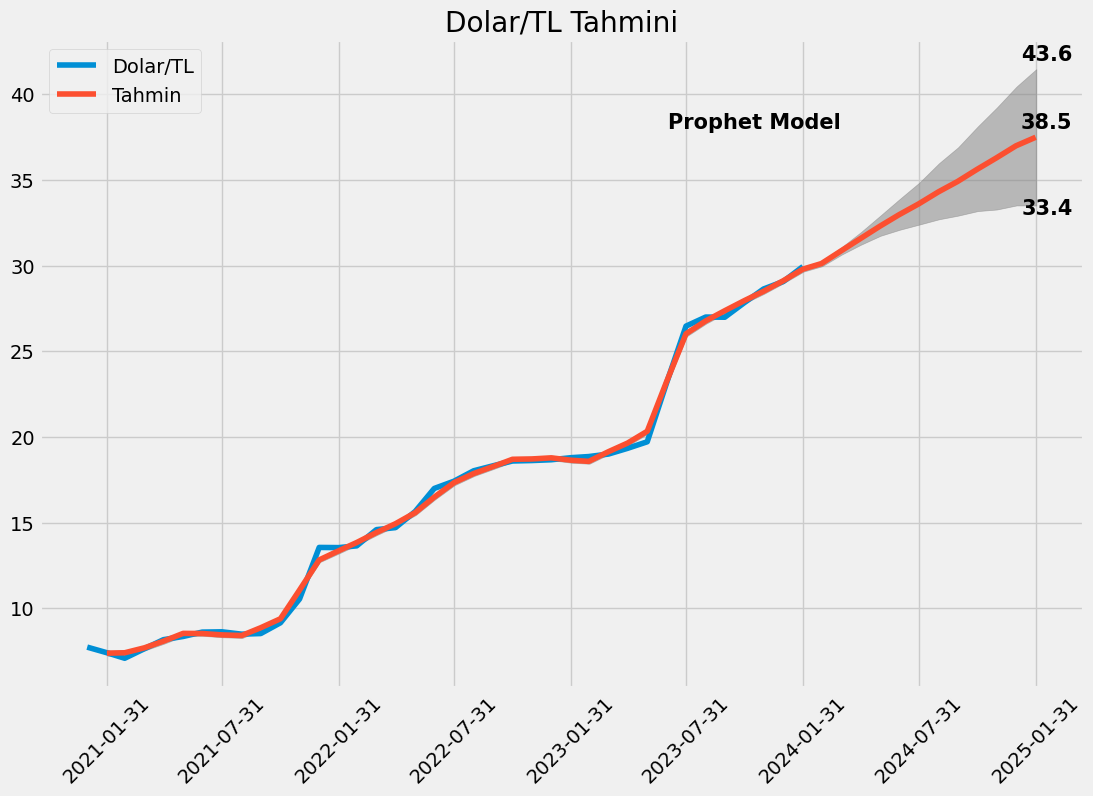

In [48]:
import matplotlib.dates as mdates
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))
plt.plot(df6["USD/TL"][-38:],label='Dolar/TL')
plt.plot(predictions["yhat"][-51:-2],label='Tahmin')
annotation_date = mdates.datestr2num('2025-03-30')
annotation_date1 = mdates.datestr2num('2024-03-30')
plt.text(annotation_date1, 38,  "Prophet Model",fontsize=15, color='black', horizontalalignment='right',fontweight='bold')
plt.text(annotation_date, 38,  str(predictions["yhat"][-1])[:4],fontsize=15, color='black', horizontalalignment='right',fontweight='bold')
plt.text(annotation_date, 33,  str(predictions["yhat_lower"][-1])[:4],fontsize=15, color='black', horizontalalignment='right',fontweight='bold')
plt.text(annotation_date, 42,  str(predictions["yhat_upper"][-1])[:4],fontsize=15, color='black', horizontalalignment='right',fontweight='bold')
plt.fill_between(predictions["yhat"][-51:-1].index.strftime("%Y-%m"), predictions["yhat_upper"][-51:-1].shift(1), predictions["yhat_lower"][-51:-1].shift(1), alpha=0.5, color='gray')
plt.xticks(predictions.index[-51:-2:6],rotation=45)
plt.title('Dolar/TL Tahmini')
plt.legend(loc=2)

In [49]:
usdtahmin=(predictions["yhat"][-15:].pct_change(periods=1)*100).dropna()
usdtahmin

ds
2024-02-29    1.085096
2024-03-31    2.462161
2024-04-30    2.296242
2024-05-31    2.312680
2024-06-30    2.069187
2024-07-31    1.925869
2024-08-31    2.083988
2024-09-30    1.755891
2024-10-31    2.052678
2024-11-30    1.853372
2024-12-31    1.953139
2025-01-31    1.352695
2025-02-28    0.984224
2025-03-31    1.776330
Name: yhat, dtype: float64

In [50]:
usdtahmin1 = []
result = df6.iloc[-1,0]
for i in range(len(usdtahmin)):
    result *= (1 + usdtahmin[i] / 100)
    usdtahmin1.append(result)

usdtahmin1 = np.array(usdtahmin1).reshape(-1, 1)
usdtahmin1 = pd.DataFrame(usdtahmin1)
usdtahmin1.columns = ["USD/TL"]
usdtahmin1=pd.concat([df6.iloc[-6:],usdtahmin1],axis=0)
usdtahmin1 = usdtahmin1.set_index(pd.date_range(start="2023-08-30", periods=len(usdtahmin1), freq="1M"))
usdtahmin1

,USD/TL
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.846114
2023-11-30,28.637082
2023-12-31,29.074857
2024-01-31,29.947753
2024-02-29,30.272715
2024-03-31,31.018078
2024-04-30,31.730328
2024-05-31,32.464149


In [85]:
import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'growth':trial.suggest_categorical('growth',['linear'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df14[50:].index
    sn["y"]=df14[50:].values
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2024-01-22 21:21:30,374] A new study created in memory with name: no-name-8f5d6ec2-264c-455f-9074-2ff426009bfb
21:21:30 - cmdstanpy - INFO - Chain [1] start processing
21:21:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-22 21:21:30,979] Trial 0 finished with value: 5.246761434928574 and parameters: {'changepoint_prior_scale': 9.329287058409566, 'changepoint_range': 0.9172591406017591, 'seasonality_prior_scale': 2.035575110043808, 'n_changepoints': 72, 'growth': 'linear'}. Best is trial 0 with value: 5.246761434928574.
21:21:31 - cmdstanpy - INFO - Chain [1] start processing
21:21:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-22 21:21:31,374] Trial 1 finished with value: 64.64921301398584 and parameters: {'changepoint_prior_scale': 4.845519784842576, 'changepoint_range': 0.7465549972465005, 'seasonality_prior_scale': 5.974949743087172, 'n_changepoints': 50, 'growth': 'linear'}. Best is trial 0 with value: 5.246761434928574.
21:21:31 - cmdstanpy - INFO - 

In [86]:
study.best_params

{'changepoint_prior_scale': 8.441645091305189,
 'changepoint_range': 0.9896533088928638,
 'seasonality_prior_scale': 6.984796984939141,
 'n_changepoints': 96,
 'growth': 'linear'}

In [87]:
sn=pd.DataFrame()
sn["ds"]=df14[50:].index
sn["y"]=df14[50:].values
prophet=Prophet(growth="linear",changepoint_prior_scale=8.441645091305189,changepoint_range=0.9896533088928638,seasonality_prior_scale=6.984796984939141,n_changepoints=96)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=13,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

21:32:59 - cmdstanpy - INFO - Chain [1] start processing
21:32:59 - cmdstanpy - INFO - Chain [1] done processing


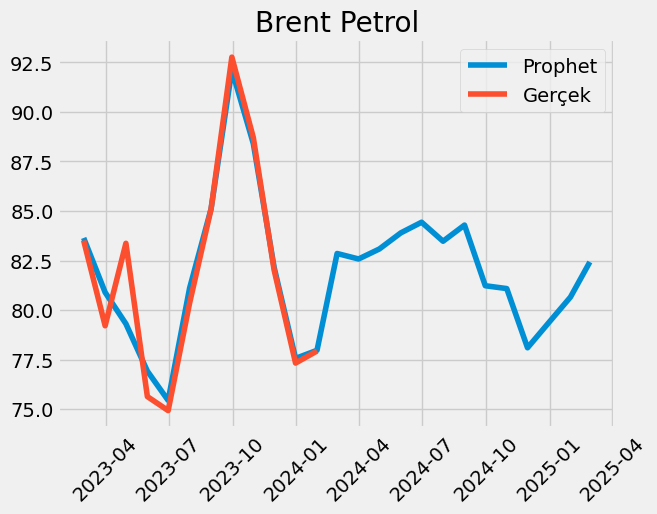

In [89]:
plt.title("Brent Petrol")
plt.plot(predictions["yhat"][-25:],label="Prophet")
plt.plot(df14["Brent"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [90]:
brenttahmin=predictions["yhat"][-17:]
brenttahmin

ds
2023-10-31    88.400811
2023-11-30    82.163837
2023-12-31    77.558623
2024-01-31    77.969502
2024-02-29    82.854587
2024-03-31    82.577378
2024-04-30    83.082074
2024-05-31    83.895253
2024-06-30    84.433060
2024-07-31    83.473382
2024-08-31    84.288705
2024-09-30    81.227254
2024-10-31    81.083611
2024-11-30    78.095004
2024-12-31    79.379044
2025-01-31    80.654903
2025-02-28    82.426516
Name: yhat, dtype: float64

In [54]:
"""brenttahmin=pd.read_csv("C:/Users/Bora/Downloads/brent_forecast.csv")
brenttahmin=brenttahmin.set_index(brenttahmin["Unnamed: 0"])
del brenttahmin["Unnamed: 0"]
brenttahmin.index.name="" 
brenttahmin"""

'brenttahmin=pd.read_csv("C:/Users/Bora/Downloads/brent_forecast.csv")\nbrenttahmin=brenttahmin.set_index(brenttahmin["Unnamed: 0"])\ndel brenttahmin["Unnamed: 0"]\nbrenttahmin.index.name="" \nbrenttahmin'

In [55]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.80),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,50),
                'growth':trial.suggest_categorical('growth',['linear'])

            

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=enf_belirsizlik[40:].index
    sn["y"]=enf_belirsizlik[40:].values
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.80),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.001,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,50),\n                \'growth\':trial.suggest_categorical(\'growth\',[\'linear\'])\n\n            \n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=enf_belirsizlik[40:].index\n    sn["y"]=enf_belirsizlik[40:].values\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=13,freq="M")\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])\n    return mae_score\

In [459]:
"""study.best_params"""

{'changepoint_prior_scale': 9.400253267584855,
 'changepoint_range': 0.7837525159119154,
 'seasonality_prior_scale': 1.7208251836729798,
 'n_changepoints': 45,
 'growth': 'linear'}

21:07:12 - cmdstanpy - INFO - Chain [1] start processing
21:07:12 - cmdstanpy - INFO - Chain [1] done processing


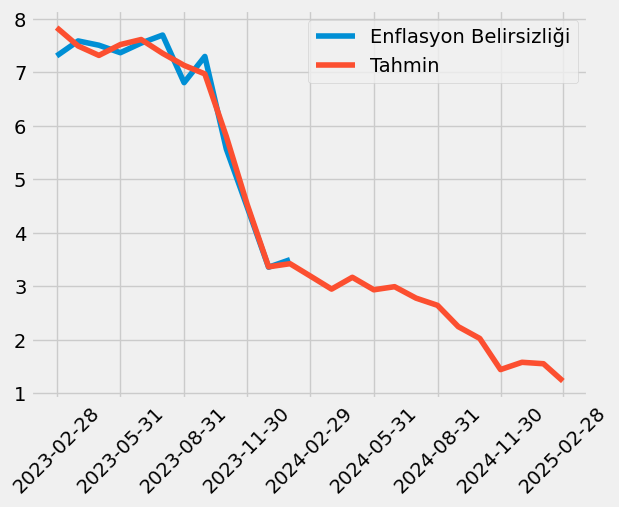

In [56]:
sn=pd.DataFrame()
sn["ds"]=enf_belirsizlik.index
sn["y"]=enf_belirsizlik.values
prophet=Prophet(changepoint_prior_scale=17.95210046456901,changepoint_range=0.9993099781087834,seasonality_prior_scale=6.849099847065717,n_changepoints=44,growth="linear")
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=13,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])
plt.plot(enf_belirsizlik[-12:],label="Enflasyon Belirsizliği")
plt.plot(predictions["yhat"][-25:],label="Tahmin")
plt.xticks(predictions.index[-25::3],rotation=45)
plt.legend()


In [57]:
enf_belirsizlik

,Enflasyon Belirsizliği
2013-06-30,0.62
2013-07-31,0.74
2013-08-31,0.74
2013-09-30,0.77
2013-10-31,0.65
...,...
2023-09-30,7.30
2023-10-31,5.57
2023-11-30,4.49
2023-12-31,3.36


In [58]:
enfbelirsizliktahmin1=pd.DataFrame(predictions["yhat"][-15:])
enfbelirsizliktahmin1.columns=["Enflasyon Belirsizliği"]
enfbelirsizliktahmin1.index.names=[""]
enfbelirsizliktahmin1.iloc[0]=3.36
enfbelirsizliktahmin1.iloc[1]=3.5
enfbelirsizliktahmin1

,Enflasyon Belirsizliği
,
2023-12-31,3.360000
2024-01-31,3.500000
2024-02-29,3.196880
2024-03-31,2.950193
2024-04-30,3.170942
2024-05-31,2.937366
2024-06-30,2.995336
2024-07-31,2.781375
2024-08-31,2.646703


In [431]:
"""model=auto_arima(enf_belirsizlik[:-12],trace=False,information_criterion='aic',seasonal=False)
enfbelirsizliktahmin1=model.predict(12)
enfbelirsizliktahmin1=pd.DataFrame(enfbelirsizliktahmin1)
enfbelirsizliktahmin1.columns=["Enflasyon Belirsizliği"]
row=pd.DataFrame({"Enflasyon Belirsizliği":enf_belirsizlik.iloc[-2:,0]},index=pd.date_range(start="2023-12-30",periods=2,freq="1M"))
enfbelirsizliktahmin1=pd.concat([row,enfbelirsizliktahmin1],axis=0)
enfbelirsizliktahmin1
"""

,Enflasyon Belirsizliği
2023-12-31,3.36
2024-01-31,3.50
2024-02-29,3.50
2024-03-31,3.50
2024-04-30,3.50
2024-05-31,3.50
2024-06-30,3.50
2024-07-31,3.50
2024-08-31,3.50
2024-09-30,3.50


In [90]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',[0.01,10]),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].index
    sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][-12:],predictions["yhat"].tail(12))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',[0.01,10]),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][p

In [91]:
#study.best_params

In [59]:
sn=pd.DataFrame()
sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][80:].index
sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][80:].values
sn["cap"]=190
prophet=Prophet(changepoint_prior_scale=3.481321992729419,changepoint_range=0.8995930316928846,growth='linear',seasonality_prior_scale=8.977376335194005,yearly_seasonality=True,weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=190
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

21:07:27 - cmdstanpy - INFO - Chain [1] start processing
21:07:27 - cmdstanpy - INFO - Chain [1] done processing


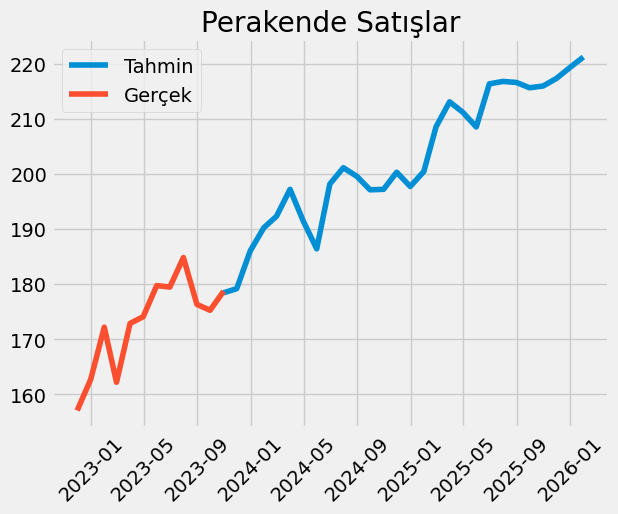

In [60]:
plt.title("Perakende Satışlar")
plt.plot(predictions["yhat"][-28:],label="Tahmin")
plt.plot(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [61]:
perakendetahmin=(predictions["yhat"][-28:].pct_change(periods=1)*100).dropna()
perakendetahmin

ds
2023-11-30    0.417766
2023-12-31    3.837414
2024-01-31    2.255112
2024-02-29    1.093496
2024-03-31    2.545369
2024-04-30   -2.901185
2024-05-31   -2.657283
2024-06-30    6.315988
2024-07-31    1.493700
2024-08-31   -0.782232
2024-09-30   -1.221874
2024-10-31    0.044657
2024-11-30    1.575699
2024-12-31   -1.293369
2025-01-31    1.373530
2025-02-28    4.050079
2025-03-31    2.179169
2025-04-30   -0.886073
2025-05-31   -1.268685
2025-06-30    3.756526
2025-07-31    0.201727
2025-08-31   -0.087168
2025-09-30   -0.445215
2025-10-31    0.148098
2025-11-30    0.628616
2025-12-31    0.911598
2026-01-31    0.878391
Name: yhat, dtype: float64

In [62]:
((usdtahmin1[2:-1].pct_change(periods=1)*100).dropna())

,USD/TL
2023-11-30,2.840498
2023-12-31,1.528701
2024-01-31,3.002237
2024-02-29,1.085096
2024-03-31,2.462161
2024-04-30,2.296242
2024-05-31,2.312680
2024-06-30,2.069187
2024-07-31,1.925869
2024-08-31,2.083988


In [91]:
brenttahmin1=(brenttahmin.pct_change()*100).dropna()
brenttahmin1

ds
2023-11-30   -7.055335
2023-12-31   -5.604916
2024-01-31    0.529766
2024-02-29    6.265378
2024-03-31   -0.334572
2024-04-30    0.611179
2024-05-31    0.978766
2024-06-30    0.641046
2024-07-31   -1.136614
2024-08-31    0.976746
2024-09-30   -3.632101
2024-10-31   -0.176841
2024-11-30   -3.685833
2024-12-31    1.644202
2025-01-31    1.607299
2025-02-28    2.196535
Name: yhat, dtype: float64

In [92]:
motorintahmin=pd.DataFrame((1+(((usdtahmin1[2:-1].pct_change(periods=1)*100).dropna())/100)).values*(1+(((brenttahmin1).dropna())/100)).values.reshape(-1,1))
motorintahmin.columns=["Motorin"]
motorintahmin=motorintahmin.set_index(pd.date_range(start="2023-11-30",periods=len(motorintahmin),freq="1M"))
motorintahmin.iloc[0,0]=(motorin.pct_change(periods=1)*100).iloc[-1,0]
motorintahmin[1:]=((motorintahmin[1:])-1)*100
motorintahmin

,Motorin
2023-11-30,7.001647
2023-12-31,-4.161898
2024-01-31,3.547908
2024-02-29,7.418459
2024-03-31,2.119351
2024-04-30,2.921456
2024-05-31,3.314081
2024-06-30,2.723498
2024-07-31,0.767365
2024-08-31,3.081089


In [99]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,50),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=money["Para Arzi"].index
    sn["y"]=money["Para Arzi"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(money["Para Arzi"],predictions["yhat"][:-12])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,50),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=money["Para Arzi"].index\n    sn["y"]=money["Para Arzi"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"

In [100]:
#study.best_params

In [93]:
sn=pd.DataFrame()
sn["ds"]=money["Para Arzi"].index
sn["y"]=money["Para Arzi"].values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=8.996871309148588,changepoint_range=0.8998520378506774,growth='linear',seasonality_prior_scale=2.6371165543447135,n_changepoints=40,yearly_seasonality=True,weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

21:34:21 - cmdstanpy - INFO - Chain [1] start processing
21:34:21 - cmdstanpy - INFO - Chain [1] done processing


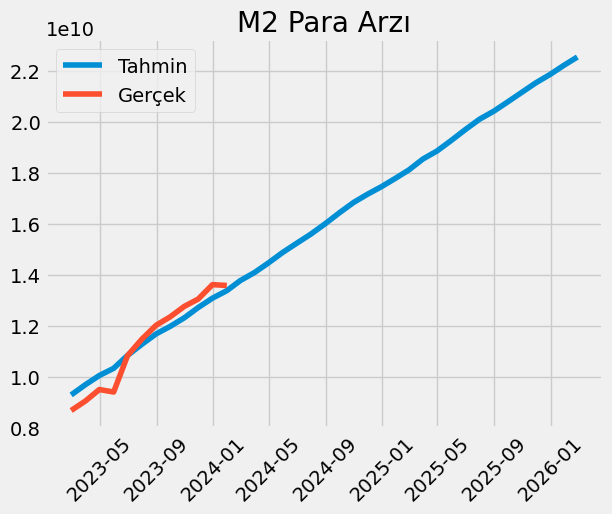

In [94]:
plt.title("M2 Para Arzı")
plt.plot(predictions["yhat"][-37:],label="Tahmin")
plt.plot(money["Para Arzi"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [95]:
paraarzitahmin=(predictions["yhat"].pct_change(periods=1)*100).tail(25)
paraarzitahmin

ds
2024-02-29    2.932282
2024-03-31    2.308287
2024-04-30    2.661437
2024-05-31    2.851300
2024-06-30    2.389269
2024-07-31    2.382520
2024-08-31    2.598208
2024-09-30    2.615774
2024-10-31    2.496454
2024-11-30    1.913465
2024-12-31    1.767620
2025-01-31    1.927332
2025-02-28    1.772257
2025-03-31    2.405921
2025-04-30    1.654005
2025-05-31    2.206554
2025-06-30    2.176205
2025-07-31    2.082399
2025-08-31    1.574417
2025-09-30    1.773449
2025-10-31    1.830053
2025-11-30    1.739843
2025-12-31    1.536159
2026-01-31    1.694576
2026-02-28    1.400914
Name: yhat, dtype: float64

In [96]:
paraarzitahmin1 = []
result = money.iloc[-1,0]
for i in range(len(paraarzitahmin)):
    result *= (1 + paraarzitahmin[i] / 100)
    paraarzitahmin1.append(result)

paraarzitahmin1 = np.array(paraarzitahmin1).reshape(-1, 1)
paraarzitahmin1 = pd.DataFrame(paraarzitahmin1)
paraarzitahmin1.columns = ["Para Arzi"]
paraarzitahmin1 = paraarzitahmin1.set_index(pd.date_range(start="2024-01-30", periods=len(paraarzitahmin1), freq="1M"))
row=pd.DataFrame({"Para Arzi":money.iloc[-4:,0]},index=pd.date_range(start="2023-09-30",periods=4,freq="M"))
paraarzitahmin1=pd.concat([row,paraarzitahmin1])
paraarzitahmin1

,Para Arzi
2023-09-30,NaN
2023-10-31,1.276379e+10
2023-11-30,1.305046e+10
2023-12-31,1.361599e+10
2024-01-31,1.398029e+10
2024-02-29,1.430300e+10
2024-03-31,1.468367e+10
2024-04-30,1.510234e+10
2024-05-31,1.546318e+10
2024-06-30,1.583159e+10


In [97]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=borc["Borç"][params["m"]:-12].index
    sn["y"]=borc["Borç"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(borc["Borç"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=borc["Borç"][params["m"]:-12].index\n    sn["y"]=borc["Borç

In [98]:
#study.best_params

In [99]:
sn=pd.DataFrame()
sn["ds"]=borc["Borç"][103:].index
sn["y"]=borc["Borç"][103:].values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=3.671534257218686,changepoint_range=0.8995013103592469,growth='linear',seasonality_prior_scale=4.464356522636207,n_changepoints=2)

prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=26,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

21:34:22 - cmdstanpy - INFO - Chain [1] start processing
21:34:22 - cmdstanpy - INFO - Chain [1] done processing


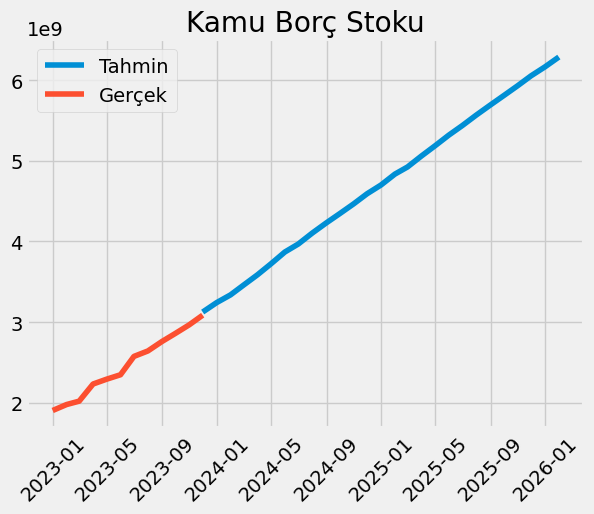

In [100]:
plt.title("Kamu Borç Stoku")
plt.plot(predictions["yhat"][-27:],label="Tahmin")
plt.plot(borc["Borç"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [101]:
borctahmin=(predictions["yhat"].pct_change(periods=1)*100).tail(26)
borctahmin

ds
2023-12-31    3.723207
2024-01-31    2.973918
2024-02-29    3.622697
2024-03-31    3.698124
2024-04-30    3.781603
2024-05-31    3.941290
2024-06-30    2.569477
2024-07-31    3.410054
2024-08-31    3.046820
2024-09-30    2.720313
2024-10-31    2.789277
2024-11-30    2.814606
2024-12-31    2.363137
2025-01-31    2.875181
2025-02-28    1.826525
2025-03-31    2.758137
2025-04-30    2.475739
2025-05-31    2.578391
2025-06-30    2.222283
2025-07-31    2.388002
2025-08-31    2.217814
2025-09-30    2.062221
2025-10-31    2.105032
2025-11-30    2.082993
2025-12-31    1.837468
2026-01-31    1.980440
Name: yhat, dtype: float64

In [102]:
borctahmin1 = []
result = borc.iloc[-1,0]
for i in range(len(borctahmin)):
    result *= (1 + borctahmin[i] / 100)
    borctahmin1.append(result)

borctahmin1 = np.array(borctahmin1).reshape(-1, 1)
borctahmin1 = pd.DataFrame(borctahmin1)
borctahmin1.columns = ["Borç"]
borctahmin1 = borctahmin1.set_index(pd.date_range(start="2023-12-30", periods=len(borctahmin1), freq="1M"))
row=pd.DataFrame({"Borç":borc.iloc[-4:,0]},index=pd.date_range(start="2023-08-30",periods=4,freq="1M"))
borctahmin1=pd.concat([row,borctahmin1],axis=0)
borctahmin1

,Borç
2023-08-31,2.758965e+09
2023-09-30,2.859751e+09
2023-10-31,2.966763e+09
2023-11-30,3.086466e+09
2023-12-31,3.201382e+09
2024-01-31,3.296589e+09
2024-02-29,3.416014e+09
2024-03-31,3.542342e+09
2024-04-30,3.676300e+09
2024-05-31,3.821193e+09


In [103]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),


                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df3["Kredi"].index
    sn["y"]=df3["Kredi"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(df3["Kredi"],predictions["yhat"][:-12])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df3["Kredi"].index\n    sn["y"]=df3["Kredi"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=pa

In [104]:
#study.best_params

In [105]:
sn=pd.DataFrame()
sn["ds"]=df3["Kredi"].index
sn["y"]=df3["Kredi"].values
prophet=Prophet(**study.best_params)

prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=13,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

21:34:22 - cmdstanpy - INFO - Chain [1] start processing


21:34:23 - cmdstanpy - INFO - Chain [1] done processing


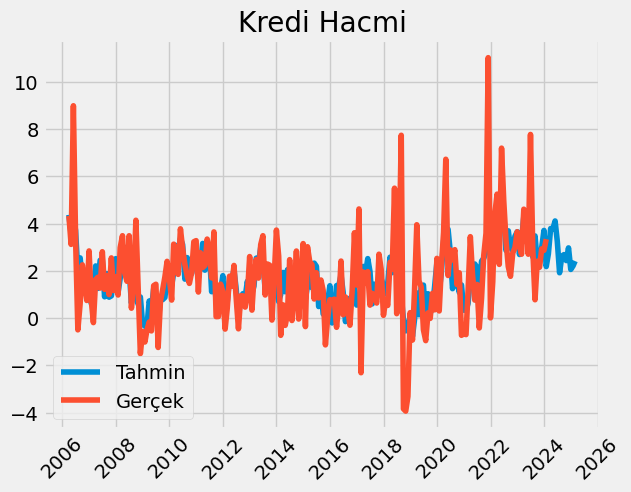

In [106]:
plt.title("Kredi Hacmi")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(df3["Kredi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [107]:
kreditahmin=(predictions["yhat"]).tail(13)
kreditahmin

ds
2024-02-29    2.720766
2024-03-31    3.796160
2024-04-30    3.771854
2024-05-31    4.116390
2024-06-30    3.252401
2024-07-31    1.922805
2024-08-31    2.631263
2024-09-30    2.691713
2024-10-31    2.438608
2024-11-30    2.976937
2024-12-31    2.064015
2025-01-31    2.215035
2025-02-28    2.418172
Name: yhat, dtype: float64

In [108]:
kreditahmin1 = kreditahmin

kreditahmin1 = np.array(kreditahmin1).reshape(-1, 1)
kreditahmin1 = pd.DataFrame(kreditahmin1)
kreditahmin1.columns = ["Kredi"]
kreditahmin1 = kreditahmin1.set_index(pd.date_range(start="2024-02-28", periods=len(kreditahmin1), freq="1M"))
row=pd.DataFrame({"Kredi":df3.iloc[-4:,0]},index=pd.date_range(start="2023-10-30",periods=4,freq="1M"))
kreditahmin1=pd.concat([row,kreditahmin1],axis=0)
kreditahmin1

,Kredi
2023-10-31,2.154973
2023-11-30,2.932091
2023-12-31,2.873464
2024-01-31,3.346965
2024-02-29,2.720766
2024-03-31,3.796160
2024-04-30,3.771854
2024-05-31,4.116390
2024-06-30,3.252401
2024-07-31,1.922805


In [109]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,200),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=m3["M3 Para Arzi"][params["m"]:-12].index
    sn["y"]=m3["M3 Para Arzi"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(m3["M3 Para Arzi"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,200),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=m3["M3 Para Arzi"][params["m"]:-12].index\n    sn["y"]=m3["M3 Para Arzi"][

In [110]:
#study.best_params

In [111]:
sn=pd.DataFrame()
sn["ds"]=m3["M3 Para Arzi"][151:].index
sn["y"]=m3["M3 Para Arzi"][151:].values
sn["cap"]=386.728728252815
prophet=Prophet(changepoint_prior_scale=1.0239522189165728,changepoint_range=0.8631788185438879,growth='logistic',seasonality_prior_scale=8.271825948806738,n_changepoints=14,yearly_seasonality="auto",weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
future_dates["cap"]=386.728728252815
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

21:34:23 - cmdstanpy - INFO - Chain [1] start processing


21:34:25 - cmdstanpy - INFO - Chain [1] done processing


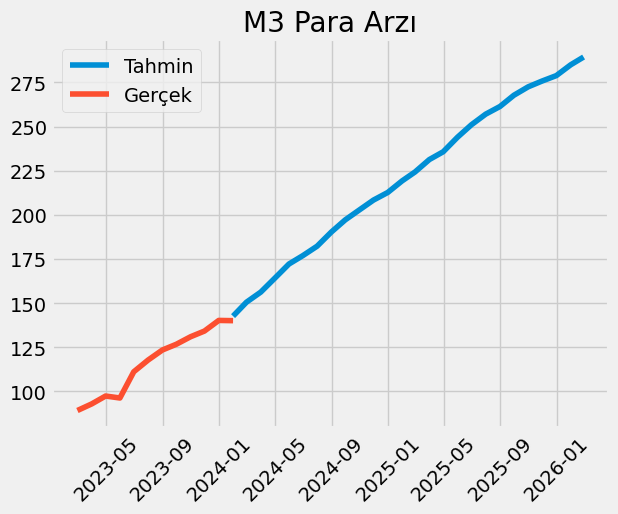

In [112]:
plt.title("M3 Para Arzı")
plt.plot(predictions["yhat"][-26:],label="Tahmin")
plt.plot(m3["M3 Para Arzi"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [113]:
m3tahmin=(predictions["yhat"].tail(26).pct_change(periods=1)*100).dropna()
m3tahmin1 = []
result = m3.iloc[-1,0]
for i in range(len(m3tahmin)):
    result *= (1 + m3tahmin[i] / 100)
    m3tahmin1.append(result)

m3tahmin1 = np.array(m3tahmin1).reshape(-1, 1)
m3tahmin1 = pd.DataFrame(m3tahmin1)
m3tahmin1.columns = ["M3"]
m3tahmin1 = m3tahmin1.set_index(pd.date_range(start="2024-02-28", periods=len(m3tahmin1), freq="1M"))
row=pd.DataFrame({"M3":m3.iloc[-4:,0]},index=pd.date_range(start="2023-10-30",periods=4,freq="1M"))
m3tahmin1=pd.concat([row,m3tahmin1],axis=0)
m3tahmin1

,M3
2023-10-31,130.934676
2023-11-30,134.161244
2023-12-31,140.183543
2024-01-31,140.049153
2024-02-29,147.794929
2024-03-31,153.413343
2024-04-30,161.056796
2024-05-31,169.033596
2024-06-30,173.693307
2024-07-31,178.962870


In [114]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=sanayi["Sanayi"].index
    sn["y"]=sanayi["Sanayi"].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=15,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sanayi["Sanayi"],predictions["yhat"][:-15])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=sanayi["Sanayi"].index\n    sn["y"]=sanayi["Sanayi"].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(cha

In [115]:
#study.best_params

In [116]:
sn=pd.DataFrame()
sn["ds"]=sanayi["Sanayi"].index
sn["y"]=sanayi["Sanayi"].values
prophet=Prophet(changepoint_prior_scale=9.619978429571834,changepoint_range=0.8872026398316396,growth='linear',seasonality_prior_scale=4.66384076344283,n_changepoints=25,yearly_seasonality="auto",weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

21:34:26 - cmdstanpy - INFO - Chain [1] start processing
21:34:26 - cmdstanpy - INFO - Chain [1] done processing


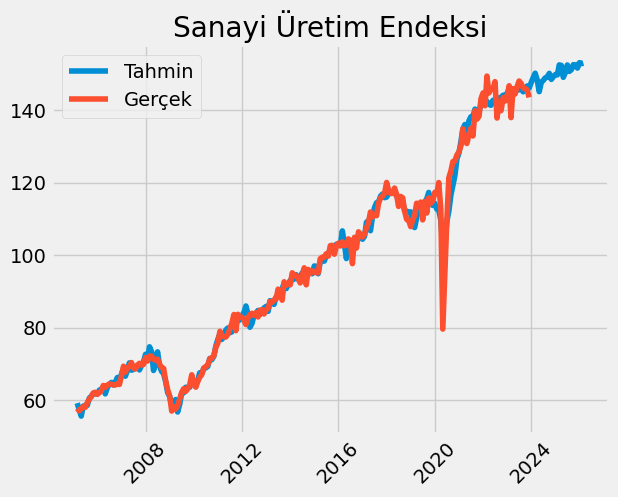

In [117]:
plt.title("Sanayi Üretim Endeksi")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(sanayi["Sanayi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [118]:
sanayitahmin=(predictions["yhat"].tail(27).pct_change(periods=1)*100).dropna()
sanayitahmin1 = []
result = sanayi.iloc[-1,0]
for i in range(len(sanayitahmin)):
    result *= (1 + sanayitahmin[i] / 100)
    sanayitahmin1.append(result)

sanayitahmin1 = np.array(sanayitahmin1).reshape(-1, 1)
sanayitahmin1 = pd.DataFrame(sanayitahmin1)
sanayitahmin1.columns = ["Sanayi"]
sanayitahmin1 = sanayitahmin1.set_index(pd.date_range(start="2023-12-30", periods=len(sanayitahmin1), freq="1M"))
#row=pd.DataFrame({"Sanayi":df3.iloc[-2:,0]},index=pd.date_range(start="2023-10-30",periods=2,freq="1M"))
#sanayitahmin1=pd.concat([row,sanayitahmin1],axis=0)
sanayitahmin1

,Sanayi
2023-12-31,144.902218
2024-01-31,146.030496
2024-02-29,144.210225
2024-03-31,141.080420
2024-04-30,143.596436
2024-05-31,144.089681
2024-06-30,144.800885
2024-07-31,145.018318
2024-08-31,145.997254
2024-09-30,144.369606


In [119]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=redkt["REDKT"][params["m"]:-36].index
    sn["y"]=redkt["REDKT"][params["m"]:-36].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=36,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(redkt["REDKT"][-36:],predictions["yhat"][-36:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=redkt["REDKT"][params["m"]:-36].index\n    sn["y"]=redkt["REDKT"][params[

In [120]:
#study.best_params

In [121]:
redkt

,REDKT
2011-03-31,111.62
2011-04-30,114.17
2011-05-31,112.89
2011-06-30,108.98
2011-07-31,104.82
...,...
2023-08-31,52.40
2023-09-30,55.53
2023-10-31,56.04
2023-11-30,55.25


In [122]:
sn=pd.DataFrame()
sn["ds"]=redkt["REDKT"].index
sn["y"]=redkt["REDKT"].values
sn["cap"]=300
prophet=Prophet(changepoint_prior_scale=4.998474885835357,
 changepoint_range=0.8719913329652468,
 growth='logistic')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
future_dates["cap"]=300
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

21:34:26 - cmdstanpy - INFO - Chain [1] start processing


21:34:27 - cmdstanpy - INFO - Chain [1] done processing


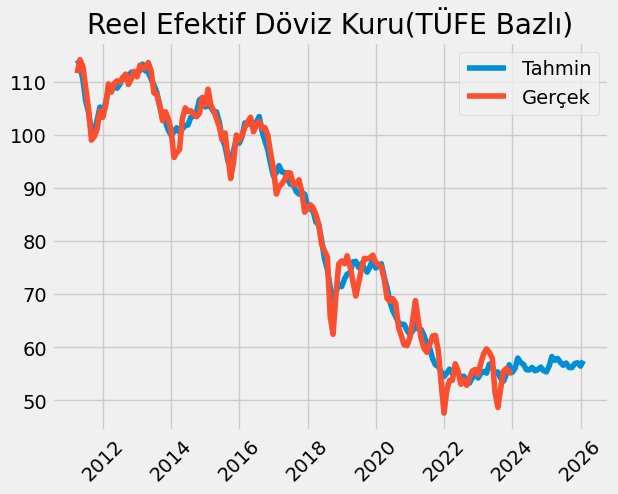

In [123]:
plt.title("Reel Efektif Döviz Kuru(TÜFE Bazlı)")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(redkt["REDKT"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [124]:
predictions["yhat"].tail(26)

ds
2023-12-31    55.290489
2024-01-31    56.048351
2024-02-29    57.995997
2024-03-31    57.149339
2024-04-30    56.797315
2024-05-31    55.794941
2024-06-30    55.748511
2024-07-31    56.221339
2024-08-31    55.600618
2024-09-30    55.793380
2024-10-31    56.275837
2024-11-30    55.636140
2024-12-31    55.379393
2025-01-31    56.522839
2025-02-28    58.264423
2025-03-31    57.572811
2025-04-30    57.895496
2025-05-31    57.155196
2025-06-30    56.628397
2025-07-31    57.053893
2025-08-31    56.225123
2025-09-30    56.182890
2025-10-31    56.944295
2025-11-30    57.106585
2025-12-31    56.471531
2026-01-31    57.493535
Name: yhat, dtype: float64

In [125]:
redkttahmin=predictions["yhat"].tail(26)
redkttahmin=pd.DataFrame(redkttahmin)
redkttahmin.columns=["REDKT"]
redkttahmin=redkttahmin.set_index(pd.date_range(start="2023-12-31",periods=len(redkttahmin),freq="1M"))
redkttahmin.iloc[0,0]=redkt.iloc[-1,0]
redkttahmin

,REDKT
2023-12-31,55.150000
2024-01-31,56.048351
2024-02-29,57.995997
2024-03-31,57.149339
2024-04-30,56.797315
2024-05-31,55.794941
2024-06-30,55.748511
2024-07-31,56.221339
2024-08-31,55.600618
2024-09-30,55.793380


In [126]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,1.0),
                'growth': trial.suggest_categorical('growth', ['logistic','linear'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=redk["REDK"].index
    sn["y"]=redk["REDK"].values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=27,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,1.0),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'logistic\',\'linear\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=redk["REDK"].index\n    sn["y"]=redk["REDK"].values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=27,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=2000)'

In [127]:
#study.best_params

In [128]:
sn=pd.DataFrame()
sn["ds"]=redk["REDK"].index
sn["y"]=redk["REDK"].values
sn["cap"]=165
prophet=Prophet(changepoint_prior_scale=4.697452368413781,
 changepoint_range=0.9845493532029166,
 growth='logistic')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=165
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

21:34:27 - cmdstanpy - INFO - Chain [1] start processing


21:34:28 - cmdstanpy - INFO - Chain [1] done processing


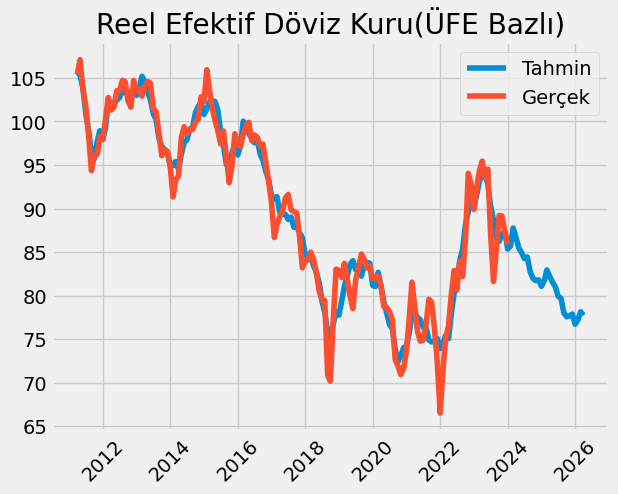

In [129]:
plt.title("Reel Efektif Döviz Kuru(ÜFE Bazlı)")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(redk["REDK"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [130]:
predictions["yhat"].tail(28)

ds
2023-12-31    85.342069
2024-01-31    85.685527
2024-02-29    87.759867
2024-03-31    86.650757
2024-04-30    85.478631
2024-05-31    84.903805
2024-06-30    84.253468
2024-07-31    84.433026
2024-08-31    82.756690
2024-09-30    81.968137
2024-10-31    81.715718
2024-11-30    81.808989
2024-12-31    81.070449
2025-01-31    81.727796
2025-02-28    82.947617
2025-03-31    82.178657
2025-04-30    81.542890
2025-05-31    80.999465
2025-06-30    79.921200
2025-07-31    79.685604
2025-08-31    78.007874
2025-09-30    77.565406
2025-10-31    77.683161
2025-11-30    77.877542
2025-12-31    76.702945
2026-01-31    77.253798
2026-02-28    78.145821
2026-03-31    77.731141
Name: yhat, dtype: float64

In [131]:
redktahmin=predictions["yhat"].tail(28)
redktahmin=pd.DataFrame(redktahmin)
redktahmin.columns=["REDK"]
redktahmin=redktahmin.set_index(pd.date_range(start="2023-12-31",periods=len(redktahmin),freq="1M"))
redktahmin.iloc[0,0]=redk.iloc[-1,0]
redktahmin

,REDK
2023-12-31,85.870000
2024-01-31,85.685527
2024-02-29,87.759867
2024-03-31,86.650757
2024-04-30,85.478631
2024-05-31,84.903805
2024-06-30,84.253468
2024-07-31,84.433026
2024-08-31,82.756690
2024-09-30,81.968137


In [132]:
motorintahmin.iloc[2]=8.4
motorintahmin.iloc[1]=-3.34

In [133]:
import statsmodels.api as sm
tahmindf=pd.DataFrame()
tahmindf=pd.concat([usdtahmin1["USD/TL"].rolling(3).mean(),paraarzitahmin1["Para Arzi"].shift(1),sanayitahmin1["Sanayi"],m3tahmin1["M3"].shift(1),borctahmin1.shift(1)],axis=1)

tahmindf=tahmindf.pct_change(periods=1)*100
#tahmindf=tahmindf.dropna(axis=0)
tahmindf["Enflasyon Belirsizliği"]=enfbelirsizliktahmin1["Enflasyon Belirsizliği"]
tahmindf["Kredi"]=kreditahmin1["Kredi"].rolling(3).mean()
tahmindf["Zam"]=zamtahmin["Zam"]
tahmindf["Motorin"]=motorintahmin["Motorin"]
tahmindf["Kredi Faizi"]=kfaiztahmin["Kredi Faizi"]
tahmindf["Mevduat Faizi"]=mfaiztahmin["Mevduat Faizi"]
tahmindf["İşsizlik"]=issizliktahmin
tahmindf["REDKT"]=redkttahmin["REDKT"]
tahmindf["REDK"]=redktahmin["REDK"]
#tahmindf["Politika Faizi"]=faiztahmin["Faiz"]
tahmindf["Perakende"]=perakendetahmin




tahmindf["Politika Faizi"]=[42.5,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45]
tahmindf=tahmindf[['USD/TL', 'Motorin', 'Kredi Faizi', 'Zam',
       'Enflasyon Belirsizliği', 'Para Arzi', 'Borç', 'Kredi', 'Mevduat Faizi','REDKT','REDK','İşsizlik','Politika Faizi']]

tahmindf.columns=["USD/TL","Motorin","Kredi Faizi","Zam","Enflasyon Belirsizliği",'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi','REDKT','REDK','İşsizlik','Politika Faizi']
tahmindf=tahmindf.dropna(axis=0)









#tahmindf.iloc[0,1]=5.76
tahmindf

,USD/TL,Motorin,Kredi Faizi,Zam,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDKT,REDK,İşsizlik,Politika Faizi
2023-12-31,2.498315,-3.340000,58.160000,0.00,3.360000,2.245991,4.034830,2.653509,52.500000,55.150000,85.870000,9.038680,45.0
2024-01-31,2.456390,8.400000,62.090000,49.11,3.500000,4.333376,3.723207,3.050840,51.050000,56.048351,85.685527,8.940522,45.0
2024-02-29,1.865890,7.418459,63.452698,0.00,3.196880,2.675575,2.973918,2.980398,49.225889,57.995997,87.759867,9.141120,45.0
2024-03-31,2.176173,2.119351,63.925203,0.00,2.950193,2.308287,3.622697,3.287964,52.137858,57.149339,86.650757,9.201787,45.0
2024-04-30,1.953752,2.921456,64.089041,0.00,3.170942,2.661437,3.698124,3.429593,52.034307,56.797315,85.478631,9.221023,45.0
2024-05-31,2.355846,3.314081,64.145850,0.00,2.937366,2.851300,3.781603,3.894801,51.398983,55.794941,84.903805,9.328421,45.0
2024-06-30,2.224302,2.723498,64.165548,0.00,2.995336,2.389269,3.941290,3.713548,51.790521,55.748511,84.253468,9.388207,45.0
2024-07-31,2.099775,0.767365,64.172379,0.00,2.781375,2.382520,2.569477,3.097199,51.848331,56.221339,84.433026,9.433416,45.0
2024-08-31,2.026429,3.081089,64.174747,0.00,2.646703,2.598208,3.410054,2.602157,51.649227,55.600618,82.756690,9.502816,45.0
2024-09-30,1.920738,-1.939986,64.175568,0.00,2.247916,2.615774,3.046820,2.415260,51.733315,55.793380,81.968137,9.556027,45.0


In [134]:
data1=pd.concat([data,tahmindf[1:]],axis=0)
data1

,USD/TL,Motorin,Kredi Faizi,Zam,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDK,REDKT,İşsizlik,Politika Faizi,TÜFE
2014-01-31,3.732429,2.881984,13.800000,14.2,0.820000,3.375162,-0.584687,2.669930,8.850000,91.320000,95.750000,9.200000,9.96,1.978080
2014-02-28,3.033477,1.685899,15.540000,0.0,0.730000,1.804994,0.808574,1.876850,10.750000,93.310000,96.630000,9.500000,10.23,0.428192
2014-03-31,2.465778,-2.278097,16.050000,0.0,0.800000,0.451349,0.193691,0.822203,11.650000,93.750000,97.250000,9.500000,10.27,1.125608
2014-04-30,-1.344724,-6.214384,15.650000,0.0,0.730000,0.796760,0.478162,-0.154556,10.750000,98.140000,102.980000,9.700000,10.03,1.344970
2014-05-31,-1.859714,-0.561578,15.360000,0.0,0.800000,-0.362357,0.091080,0.146305,10.430000,99.400000,105.100000,9.700000,9.53,0.395224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31,1.963888,1.872206,64.175853,0.0,2.027988,2.496454,2.720313,2.587195,51.772538,81.715718,56.275837,9.603006,45.00,NaN
2024-11-30,1.887836,-1.900773,64.175952,0.0,1.445645,1.913465,2.789277,2.702419,51.715126,81.808989,55.636140,9.667269,45.00,NaN
2024-12-31,1.952395,3.629455,64.175986,0.0,1.581881,1.767620,2.814606,2.493187,50.435066,81.070449,55.379393,9.725015,45.00,NaN
2025-01-31,1.716536,2.981735,64.175998,30.0,1.555001,1.927332,2.363137,2.418662,49.156991,81.727796,56.522839,9.779304,45.00,NaN


In [135]:
data1.loc["2023-10-31","TÜFE"]-=0.22
data1.loc["2023-11-30","TÜFE"]-=1.01
data1.loc["2023-12-31","TÜFE"]-=0.33

In [136]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler = StandardScaler()
scaled_data["TÜFE"]=scaler.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data

,USD/TL,Motorin,Kredi Faizi,Zam,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDK,REDKT,İşsizlik,Politika Faizi,TÜFE
0,0.457278,0.111829,-0.780353,1.139242,-0.610976,0.392034,-1.140085,0.548373,-0.854241,0.531860,1.051145,-0.992721,-0.616950,0.092677
1,0.241114,-0.055393,-0.670896,-0.299260,-0.644772,-0.195573,-0.487476,0.019855,-0.709164,0.759073,1.098080,-0.820202,-0.593294,-0.601670
2,0.065543,-0.609589,-0.638814,-0.299260,-0.618486,-0.702151,-0.775489,-0.682975,-0.640443,0.809311,1.131149,-0.820202,-0.589789,-0.289229
3,-1.112922,-1.159912,-0.663977,-0.299260,-0.644772,-0.572887,-0.642242,-1.333898,-0.709164,1.310548,1.436764,-0.705189,-0.610817,-0.190955
4,-1.272192,-0.369607,-0.682219,-0.299260,-0.618486,-1.006666,-0.823552,-1.133401,-0.733598,1.454411,1.549836,-0.705189,-0.654624,-0.616440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,-0.089675,-0.029345,2.388606,-0.299260,-0.157371,0.063193,0.407990,0.493238,2.423161,-0.564729,-1.054247,-0.760967,2.453062,NaN
130,-0.113195,-0.556836,2.388612,-0.299260,-0.376044,-0.154980,0.440293,0.570025,2.418777,-0.554079,-1.088366,-0.724012,2.453062,NaN
131,-0.093230,0.216331,2.388614,-0.299260,-0.324886,-0.209560,0.452157,0.430590,2.321037,-0.638404,-1.102060,-0.690804,2.453062,NaN
132,-0.166173,0.125775,2.388615,2.739829,-0.334980,-0.149791,0.240687,0.380926,2.223448,-0.563350,-1.041073,-0.659584,2.453062,NaN


In [137]:
from sklearn.model_selection import train_test_split
X=scaled_data
X=X.iloc[:,:-1][:-14]
y=scaled_data["TÜFE"][:-14]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X_train,X_test=X[:-12,:],X[-12:,:]
y_train,y_test=y[:-12],y[-12:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=0)


In [138]:
"""import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout
def objective(trial):
    # Define hyperparameters to be optimized
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-4)
    units1 = trial.suggest_int('units1', 1, 300)
    activation1 = trial.suggest_categorical('activation1', ['tanh'])
    optimizer = trial.suggest_categorical('optimizer', ['rmsprop'])


    early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
    keras.utils.set_random_seed(42)
    model = Sequential()    
    model.add(LSTM(units=units1,activation=activation1,input_shape=(X_train.shape[1],1)))
    model.add(Dense(1))

    if optimizer == 'adam':
       optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
       optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    

    

    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])

    # Train model
    model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val,y_val), callbacks=[early_stopping],verbose=0)

    # Evaluate model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_pred))

    return mse  # Return validation accuracy as the objective
"""

"import optuna\nimport tensorflow as tf\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import LSTM, Dense\nfrom keras import regularizers\nfrom keras.layers import LSTM, Dense, Dropout\ndef objective(trial):\n    # Define hyperparameters to be optimized\n    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-4)\n    units1 = trial.suggest_int('units1', 1, 300)\n    activation1 = trial.suggest_categorical('activation1', ['tanh'])\n    optimizer = trial.suggest_categorical('optimizer', ['rmsprop'])\n\n\n    early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)\n    keras.utils.set_random_seed(42)\n    model = Sequential()    \n    model.add(LSTM(units=units1,activation=activation1,input_shape=(X_train.shape[1],1)))\n    model.add(Dense(1))\n\n    if optimizer == 'adam':\n       optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)\n    elif optimizer == 'rmsprop':\n       optimizer = tf.keras

In [139]:
"""study = optuna.create_study(direction='minimize')  # or 'minimize' depending on your objective
study.optimize(objective, n_trials=500)  # You can adjust the number of trials

# Print the best hyperparameters
print('Best hyperparameters:', study.best_params)"""

"study = optuna.create_study(direction='minimize')  # or 'minimize' depending on your objective\nstudy.optimize(objective, n_trials=500)  # You can adjust the number of trials\n\n# Print the best hyperparameters\nprint('Best hyperparameters:', study.best_params)"

In [140]:
import keras
from keras import Sequential
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=500, restore_best_weights=True)
from keras.regularizers import l2

keras.utils.set_random_seed(42)
model = Sequential()
model.add(LSTM(units=63,activation='tanh',input_shape=(X_train.shape[1],1)))
model.add(Dense(1))
optimizer = keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val,y_val),verbose=1,callbacks=[early_stopping])



Epoch 1/100


7/7 [==============================] - 4s 182ms/step - loss: 0.8464 - mean_squared_error: 0.8464 - val_loss: 0.1782 - val_mean_squared_error: 0.1782
Epoch 2/100
7/7 [==============================] - 0s 17ms/step - loss: 0.8326 - mean_squared_error: 0.8326 - val_loss: 0.1726 - val_mean_squared_error: 0.1726
Epoch 3/100
7/7 [==============================] - 0s 15ms/step - loss: 0.8202 - mean_squared_error: 0.8202 - val_loss: 0.1666 - val_mean_squared_error: 0.1666
Epoch 4/100
7/7 [==============================] - 0s 15ms/step - loss: 0.8075 - mean_squared_error: 0.8075 - val_loss: 0.1630 - val_mean_squared_error: 0.1630
Epoch 5/100
7/7 [==============================] - 0s 14ms/step - loss: 0.7966 - mean_squared_error: 0.7966 - val_loss: 0.1577 - val_mean_squared_error: 0.1577
Epoch 6/100
7/7 [==============================] - 0s 14ms/step - loss: 0.7832 - mean_squared_error: 0.7832 - val_loss: 0.1535 - val_mean_squared_error: 0.1535
Epoch 7/100
7/7 [==================

In [141]:
mean_squared_error(scaler.inverse_transform(y_test),scaler.inverse_transform(model.predict(X_test)))

1/1 [==============================] - 1s 654ms/step


1.4028011407327827

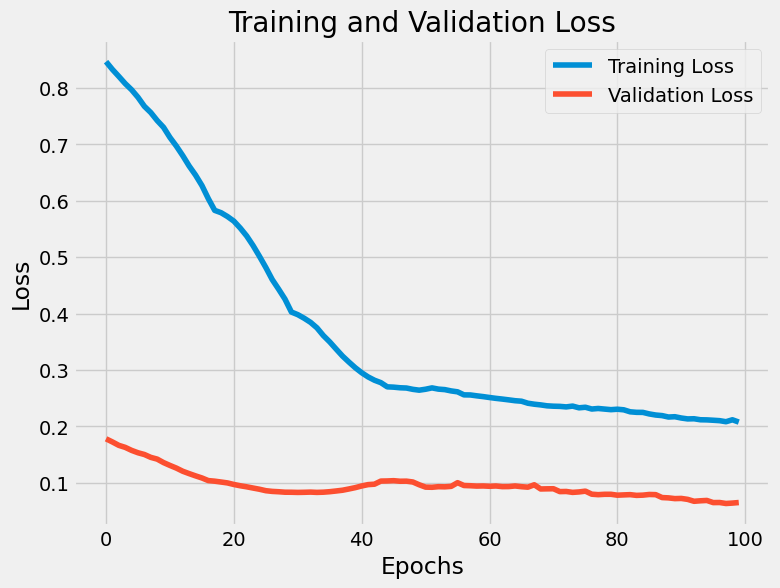

In [142]:
# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [143]:
tahminler=pd.DataFrame(index=pd.date_range(start="2023-01-31",periods=12,freq="1M"))
tahminler["TÜFE"]=scaler.inverse_transform(y_test)
tahminler["Tahmin"]=scaler.inverse_transform(model.predict(X_test))
tahminler.iloc[4,:]-=2.88
tahminler.iloc[9,:]+=0.22
tahminler.iloc[10,:]+=1.01
tahminler.iloc[11,:]+=0.33
tahminler

1/1 [==============================] - 0s 37ms/step


,TÜFE,Tahmin
2023-01-31,6.648943,5.956154
2023-02-28,3.145046,1.973175
2023-03-31,2.289480,2.311486
2023-04-30,2.385509,4.019845
2023-05-31,-2.836924,-0.181904
2023-06-30,3.920498,5.588374
2023-07-31,9.488824,9.638913
2023-08-31,9.086793,8.055451
2023-09-30,4.753114,5.477253
2023-10-31,3.433981,3.407701


In [144]:
early_stopping = EarlyStopping(monitor='val_loss', patience=500, restore_best_weights=True)
from keras.regularizers import l2

keras.utils.set_random_seed(42)
model = Sequential()
model.add(LSTM(units=63,activation='tanh',input_shape=(X_train.shape[1],1)))
model.add(Dense(1))
optimizer = keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X, y, epochs=100, batch_size=16, validation_data=(X_val,y_val),verbose=1,callbacks=[early_stopping])

Epoch 1/100
8/8 [==============================] - 4s 120ms/step - loss: 0.9546 - mean_squared_error: 0.9546 - val_loss: 0.1816 - val_mean_squared_error: 0.1816
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.9351 - mean_squared_error: 0.9351 - val_loss: 0.1778 - val_mean_squared_error: 0.1778
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 0.9183 - mean_squared_error: 0.9183 - val_loss: 0.1737 - val_mean_squared_error: 0.1737
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 0.9001 - mean_squared_error: 0.9001 - val_loss: 0.1692 - val_mean_squared_error: 0.1692
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 0.8816 - mean_squared_error: 0.8816 - val_loss: 0.1652 - val_mean_squared_error: 0.1652
Epoch 6/100
8/8 [==============================] - 0s 12ms/step - loss: 0.8608 - mean_squared_error: 0.8608 - val_loss: 0.1607 - val_mean_squared_error: 0.1607
Epoch 7/100
8/8 [======================

In [145]:
pred=scaler.inverse_transform(model.predict(np.array(scaled_data.iloc[-14:,:-1])))
pred=pd.DataFrame(pred)
pred.columns=["TÜFE"]
pred=pred.set_index(pd.date_range(start="2024-01-31",periods=14,freq="1M"))
pred

1/1 [==============================] - 1s 591ms/step


,TÜFE
2024-01-31,6.979068
2024-02-29,3.329895
2024-03-31,2.968182
2024-04-30,3.110925
2024-05-31,3.299462
2024-06-30,3.144573
2024-07-31,2.624253
2024-08-31,2.841238
2024-09-30,2.277388
2024-10-31,2.509148


In [146]:
tüfetahmin0 = []
result = 1859.38
pred=np.array(pred).reshape(1,-1).ravel()
for i in range(len(pred)):
    result *= (1 + (pred[i] / 100))
    tüfetahmin0.append(result)

tüfetahmin0 = np.array(tüfetahmin0).reshape(-1, 1)
tüfetahmin0 = pd.DataFrame(tüfetahmin0)
tüfetahmin0.columns = ["LSTM"]
tüfetahmin0 = tüfetahmin0.set_index(pd.date_range(start="2024-01-30", periods=len(tüfetahmin0), freq="1M"))
tüfetahmin0

,LSTM
2024-01-31,1989.147400
2024-02-29,2055.383925
2024-03-31,2116.391452
2024-04-30,2182.230812
2024-05-31,2254.232696
2024-06-30,2325.118693
2024-07-31,2386.135680
2024-08-31,2453.931469
2024-09-30,2509.817018
2024-10-31,2572.792038


In [147]:
data.loc["2023-05-31","TÜFE"]+=2.88

In [552]:
features=['USD/TL', 'Motorin', 'Kredi Faizi', 'Zam', 'Enflasyon Belirsizliği',
       'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDKT', 'REDK',
       'İşsizlik', 'Politika Faizi']
X=data[features]
y=data[["TÜFE"]]
y_pred=pd.DataFrame()
for r in range(5, 11):
        for combo in combinations(features, r):
            selected_features = list(combo)
            if 'Zam' not in selected_features:
                  selected_features.append('Zam')
            X_subset = X[selected_features]
            reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=100, tol=1e-3))
            reg.fit(X_subset, y)
            y_pred[f'Tahmin_{r}_{selected_features}'] = reg.predict(tahmindf[selected_features])


            

In [553]:
sonstd=y_pred.iloc[0,:].std()
ocaktahmin=y_pred.iloc[1,:].mean()

In [554]:
new_df = pd.DataFrame()
for index, row in y_pred.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred=y_pred[cols.values]

In [555]:
def std(i):
   std=-1*(50*(y_pred.iloc[i,:].std())/sonstd)
   std=int(std)
   return std
std1=pd.DataFrame(index=range(13))
for i in range(13):
   std1[str(i)]=std(i)
std1=std1.iloc[0,:]
std1

0    -34
1    -40
2    -44
3    -33
4    -34
5    -35
6    -34
7    -32
8    -33
9    -35
10   -34
11   -36
12   -37
Name: 0, dtype: int64

In [556]:
import numpy as np
import matplotlib.pyplot as plt
average_of_most_frequent=[]
for i in range(13):
   hist, edges = np.histogram(y_pred.iloc[i+1,:], bins=1000)
   max_freq_indices = np.argsort(hist)[std1[i]:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
sgdaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-01-31",periods=13,freq="M"))
sgdaylık.columns=["TÜFE"]
sgdaylık.iloc[0,0]=ocaktahmin
sgdaylık

,TÜFE
2024-01-31,6.692463
2024-02-29,3.426021
2024-03-31,3.149127
2024-04-30,3.228166
2024-05-31,3.252641
2024-06-30,3.198610
2024-07-31,3.002693
2024-08-31,3.180672
2024-09-30,2.737362
2024-10-31,2.930085


In [557]:

tüfetahmin1 = []
result = 1859.38
sgdaylık=np.array(sgdaylık).reshape(1,-1).ravel()
for i in range(len(sgdaylık)):
    result *= (1 + (sgdaylık[i] / 100))
    tüfetahmin1.append(result)

tüfetahmin1 = np.array(tüfetahmin1).reshape(-1, 1)
tüfetahmin1 = pd.DataFrame(tüfetahmin1)
tüfetahmin1.columns = ["SGD Regressor"]
tüfetahmin1 = tüfetahmin1.set_index(pd.date_range(start="2024-01-30", periods=len(tüfetahmin1), freq="1M"))
tüfetahmin1

,SGD Regressor
2024-01-31,1983.818320
2024-02-29,2051.784349
2024-03-31,2116.397640
2024-04-30,2184.718472
2024-05-31,2255.779511
2024-06-30,2327.933110
2024-07-31,2397.833790
2024-08-31,2474.101006
2024-09-30,2541.826115
2024-10-31,2616.303768


In [558]:
features=['USD/TL', 'Motorin', 'Kredi Faizi', 'Zam', 'Enflasyon Belirsizliği',
       'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDKT', 'REDK',
       'İşsizlik', 'Politika Faizi']
X=data[features]
y=data[["TÜFE"]]
y_pred1=pd.DataFrame(index=pd.date_range(start="2023-12-30",freq="M",periods=15))
for r in range(5, 11):
        for combo in combinations(features, r):
            selected_features = list(combo)
            if 'Zam' not in selected_features:
                  selected_features.append('Zam')
            X_subset = X[selected_features]
            model=LinearRegression()
            model.fit(X_subset, y)
            y_pred1[f'Tahmin_{r}_{selected_features}'] = model.predict(np.array(tahmindf[selected_features]))


In [559]:
sonstd=y_pred1.iloc[0,:].std()
ocaktahmin=y_pred1.iloc[1,:].mean()

In [560]:
new_df = pd.DataFrame()
for index, row in y_pred1.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred1=y_pred1[cols.values]

In [561]:
def std(i):
   std=-1*(50*(y_pred1.iloc[i,:].std())/sonstd)
   std=int(std)
   return std
std1=pd.DataFrame(index=range(13))
for i in range(15):
   std1[str(i)]=std(i)
std1=std1.iloc[0,:]
std1

0    -32
1    -44
2    -49
3    -37
4    -39
5    -42
6    -40
7    -36
8    -37
9    -36
10   -38
11   -39
12   -42
13   -44
14   -44
Name: 0, dtype: int64

In [562]:
import numpy as np
import matplotlib.pyplot as plt
average_of_most_frequent=[]
for i in range(13):
   hist, edges = np.histogram(y_pred1.iloc[i+1,:], bins=1000)
   max_freq_indices = np.argsort(hist)[std1[i]:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
linearaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-01-31",periods=13,freq="M"))
linearaylık.columns=["TÜFE"]
linearaylık.iloc[0,0]=ocaktahmin
linearaylık

,TÜFE
2024-01-31,6.474937
2024-02-29,3.306553
2024-03-31,3.060236
2024-04-30,3.219031
2024-05-31,3.319755
2024-06-30,3.176590
2024-07-31,2.942067
2024-08-31,3.099351
2024-09-30,2.651358
2024-10-31,2.854298


In [563]:
linearaylık=np.array(linearaylık)
linearaylık=linearaylık.ravel()
tüfetahmin2=[]
result=1859.38
for i in range(len(linearaylık)):
    result *= (1 + linearaylık[i] / 100)
    tüfetahmin2.append(result)

tüfetahmin2 = np.array(tüfetahmin2).reshape(-1, 1)
tüfetahmin2 = pd.DataFrame(tüfetahmin2)
tüfetahmin2.columns = ["Linear Regression"]
tüfetahmin2 = tüfetahmin2.set_index(pd.date_range(start="2024-01-30", periods=len(tüfetahmin2), freq="1M"))
tüfetahmin2


,Linear Regression
2024-01-31,1979.773675
2024-02-29,2045.235944
2024-03-31,2107.825000
2024-04-30,2175.676536
2024-05-31,2247.903662
2024-06-30,2319.310356
2024-07-31,2387.546015
2024-08-31,2461.544449
2024-09-30,2526.808793
2024-10-31,2598.931434


In [564]:
features=['USD/TL', 'Motorin', 'Kredi Faizi', 'Zam', 'Enflasyon Belirsizliği',
       'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDKT', 'REDK',
       'İşsizlik', 'Politika Faizi']
X=data[features]
y=data[["TÜFE"]]
y_pred2=pd.DataFrame(index=pd.date_range(start="2023-12-30",freq="M",periods=15))
for r in range(5, 11):
        for combo in combinations(features, r):
            selected_features = list(combo)
            if 'Zam' not in selected_features:
                  selected_features.append('Zam')
            X_subset = X[selected_features]
            reg = linear_model.Lasso(alpha=0.001)
            reg.fit(X_subset,y)
            y_pred2[f'Tahmin_{r}_{selected_features}'] = reg.predict(tahmindf[selected_features])

In [565]:
sonstd=y_pred2.iloc[0,:].std()
ocaktahmin=y_pred2.iloc[1,:].mean()

In [566]:
new_df = pd.DataFrame()
for index, row in y_pred2.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred2=y_pred2[cols.values]

In [567]:
def std(i):
   std=-1*(50*(y_pred2.iloc[i,:].std())/sonstd)
   std=int(std)
   return std
std1=pd.DataFrame(index=range(13))
for i in range(13):
   std1[str(i)]=std(i)
std1=std1.iloc[0,:]
std1


0    -32
1    -44
2    -48
3    -36
4    -39
5    -42
6    -40
7    -36
8    -37
9    -36
10   -38
11   -39
12   -42
Name: 0, dtype: int64

In [569]:
import numpy as np
import matplotlib.pyplot as plt
average_of_most_frequent=[]
for i in range(13):
   hist, edges = np.histogram(y_pred2.iloc[i+1,:], bins=1000)
   max_freq_indices = np.argsort(hist)[std1[i]:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
lassoaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-01-31",periods=13,freq="M"))
lassoaylık.columns=["TÜFE"]
lassoaylık.iloc[0,0]=ocaktahmin
lassoaylık

,TÜFE
2024-01-31,6.476545
2024-02-29,3.311255
2024-03-31,3.061865
2024-04-30,3.190368
2024-05-31,3.308085
2024-06-30,3.218536
2024-07-31,2.939112
2024-08-31,3.064393
2024-09-30,2.631524
2024-10-31,2.864918


In [570]:



tüfetahmin5 = []
result = 1859.38
lassoaylık=np.array(lassoaylık).ravel()
for i in range(len(lassoaylık)):
    result *= (1 + lassoaylık[i] / 100)
    tüfetahmin5.append(result)

tüfetahmin5 = np.array(tüfetahmin5).reshape(-1, 1)
tüfetahmin5 = pd.DataFrame(tüfetahmin5)
tüfetahmin5.columns = ["Lasso Regression"]
tüfetahmin5 = tüfetahmin5.set_index(pd.date_range(start="2024-01-30", periods=len(tüfetahmin5), freq="1M"))
tüfetahmin5

,Lasso Regression
2024-01-31,1979.803577
2024-02-29,2045.359930
2024-03-31,2107.986098
2024-04-30,2175.238623
2024-05-31,2247.197372
2024-06-30,2319.524220
2024-07-31,2387.697629
2024-08-31,2460.866067
2024-09-30,2525.624348
2024-10-31,2597.981409


In [572]:
features=['USD/TL', 'Motorin', 'Kredi Faizi', 'Zam', 'Enflasyon Belirsizliği',
       'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDKT', 'REDK',
       'İşsizlik', 'Politika Faizi']
X=data[features]
y=data[["TÜFE"]]
y_pred3=pd.DataFrame(index=pd.date_range(start="2023-12-30",freq="M",periods=15))
for r in range(5, 11):
        for combo in combinations(features, r):
            selected_features = list(combo)
            if 'Zam' not in selected_features:
                  selected_features.append('Zam')
            X_subset = X[selected_features]
            reg = linear_model.Lars(random_state=0)
            reg.fit(X_subset,y)
            y_pred3[f'Tahmin_{r}_{selected_features}'] = reg.predict(tahmindf[selected_features])
sonstd=y_pred3.iloc[0,:].std()
ocaktahmin=y_pred3.iloc[1,:].mean()

In [573]:
new_df = pd.DataFrame()
for index, row in y_pred3.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred3=y_pred3[cols.values]


In [574]:
def std(i):
   std=-1*(50*(y_pred3.iloc[i,:].std())/sonstd)
   std=int(std)
   return std
std1=pd.DataFrame(index=range(13))
for i in range(13):
   std1[str(i)]=std(i)
std1=std1.iloc[0,:]
std1


0    -33
1    -46
2    -52
3    -40
4    -42
5    -45
6    -42
7    -39
8    -39
9    -38
10   -41
11   -42
12   -45
Name: 0, dtype: int64

In [575]:

average_of_most_frequent=[]
for i in range(13):
   hist, edges = np.histogram(y_pred3.iloc[i+1,:], bins=1000)
   max_freq_indices = np.argsort(hist)[std1[i]:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
larsaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-01-31",periods=13,freq="M"))
larsaylık.columns=["TÜFE"]
larsaylık.iloc[0,0]=ocaktahmin
larsaylık

,TÜFE
2024-01-31,6.461766
2024-02-29,3.366427
2024-03-31,3.094010
2024-04-30,3.177495
2024-05-31,3.291329
2024-06-30,3.174861
2024-07-31,2.931219
2024-08-31,3.112346
2024-09-30,2.611446
2024-10-31,2.864839


In [576]:



tüfetahmin6 = []
result = 1859.38
larstahmin=np.array(larsaylık).ravel()
for i in range(len(larstahmin)):
    result *= (1 + larstahmin[i] / 100)
    tüfetahmin6.append(result)

tüfetahmin6 = np.array(tüfetahmin6).reshape(-1, 1)
tüfetahmin6 = pd.DataFrame(tüfetahmin6)
tüfetahmin6.columns = ["Lars Regression"]
tüfetahmin6 = tüfetahmin6.set_index(pd.date_range(start="2024-01-30", periods=len(tüfetahmin6), freq="1M"))
tüfetahmin6


,Lars Regression
2024-01-31,1979.528790
2024-02-29,2046.168173
2024-03-31,2109.476825
2024-04-30,2176.505344
2024-05-31,2248.141294
2024-06-30,2319.516660
2024-07-31,2387.506774
2024-08-31,2461.814237
2024-09-30,2526.103186
2024-10-31,2598.471967


In [577]:
features=['USD/TL', 'Motorin', 'Kredi Faizi', 'Zam', 'Enflasyon Belirsizliği',
       'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDKT']
X=data[features]
y=data[["TÜFE"]]
y_pred4=pd.DataFrame(index=pd.date_range(start="2023-12-30",freq="M",periods=15))
for r in range(5, 11):
        for combo in combinations(features, r):
            selected_features = list(combo)
            if 'Zam' not in selected_features:
                  selected_features.append('Zam')
            X_subset = X[selected_features]
            krr = KernelRidge()
            krr.fit(X_subset,y)
            y_pred4[f'Tahmin_{r}_{selected_features}'] = krr.predict(tahmindf[selected_features])
sonstd=y_pred4.iloc[0,:].std()
ocaktahmin=y_pred4.iloc[1,:].mean()

In [578]:
new_df = pd.DataFrame()
for index, row in y_pred4.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred4=y_pred4[cols.values]

In [579]:
def std(i):
   std=-1*(50*(y_pred4.iloc[i,:].std())/sonstd)
   std=int(std)
   return std
std1=pd.DataFrame(index=range(13))
for i in range(13):
   std1[str(i)]=std(i)
std1=std1.iloc[0,:]
std1

0    -36
1    -46
2    -45
3    -40
4    -41
5    -42
6    -41
7    -39
8    -40
9    -40
10   -42
11   -43
12   -45
Name: 0, dtype: int64

In [580]:
average_of_most_frequent=[]
for i in range(13):
   hist, edges = np.histogram(y_pred4.iloc[i+1,:], bins=1000)
   max_freq_indices = np.argsort(hist)[std1[i]:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
kernelaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-01-31",periods=13,freq="M"))
kernelaylık.columns=["TÜFE"]
kernelaylık.iloc[0,0]=ocaktahmin
kernelaylık

,TÜFE
2024-01-31,6.452384
2024-02-29,3.186557
2024-03-31,2.866081
2024-04-30,3.001968
2024-05-31,3.107466
2024-06-30,2.826792
2024-07-31,2.677406
2024-08-31,2.969733
2024-09-30,2.313027
2024-10-31,2.693990


In [581]:


tüfetahmin7 = []
result = 1859.38
krrtahmin=np.array(kernelaylık).ravel()
for i in range(len(krrtahmin)):
    result *= (1 + krrtahmin[i] / 100)
    tüfetahmin7.append(result)

tüfetahmin7 = np.array(tüfetahmin7).reshape(-1, 1)
tüfetahmin7 = pd.DataFrame(tüfetahmin7)
tüfetahmin7.columns = ["Kernel Regression"]
tüfetahmin7 = tüfetahmin7.set_index(pd.date_range(start="2024-01-30", periods=len(tüfetahmin7), freq="1M"))
tüfetahmin7

,Kernel Regression
2024-01-31,1979.354331
2024-02-29,2042.427577
2024-03-31,2100.965204
2024-04-30,2164.035503
2024-05-31,2231.282167
2024-06-30,2294.355877
2024-07-31,2355.785109
2024-08-31,2425.745627
2024-09-30,2481.853767
2024-10-31,2548.714654


In [582]:
features=['USD/TL', 'Motorin', 'Kredi Faizi', 'Zam', 'Enflasyon Belirsizliği',
       'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDKT', 'REDK',
       'İşsizlik', 'Politika Faizi']
X=data[features]
y=data[["TÜFE"]]
y_pred5=pd.DataFrame(index=pd.date_range(start="2023-12-30",freq="M",periods=15))
for r in range(5, 11):
        for combo in combinations(features, r):
            selected_features = list(combo)
            if 'Zam' not in selected_features:
                  selected_features.append('Zam')
            X_subset = X[selected_features]
            kernel = DotProduct() + WhiteKernel()
            gpr = GaussianProcessRegressor(kernel=kernel)
            gpr.fit(X_subset, y)
            y_pred5[f'Tahmin_{r}_{selected_features}'] = gpr.predict(tahmindf[selected_features])
sonstd=y_pred5.iloc[0,:].std()
ocaktahmin=y_pred5.iloc[1,:].mean()

In [583]:
new_df = pd.DataFrame()
for index, row in y_pred5.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred5=y_pred5[cols.values]

In [584]:
def std(i):
   std=-1*(50*(y_pred5.iloc[i,:].std())/sonstd)
   std=int(std)
   return std
std1=pd.DataFrame(index=range(13))
for i in range(13):
   std1[str(i)]=std(i)
std1=std1.iloc[0,:]
std1

0    -33
1    -44
2    -48
3    -37
4    -39
5    -42
6    -40
7    -37
8    -37
9    -37
10   -39
11   -40
12   -43
Name: 0, dtype: int64

In [585]:
average_of_most_frequent=[]
for i in range(13):
   hist, edges = np.histogram(y_pred5.iloc[i+1,:], bins=1000)
   max_freq_indices = np.argsort(hist)[std1[i]:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
gaussaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-01-31",periods=13,freq="M"))
gaussaylık.columns=["TÜFE"]
gaussaylık.iloc[0,0]=ocaktahmin
gaussaylık

,TÜFE
2024-01-31,6.551610
2024-02-29,3.415174
2024-03-31,3.102167
2024-04-30,3.221418
2024-05-31,3.343905
2024-06-30,3.255284
2024-07-31,2.969372
2024-08-31,3.133237
2024-09-30,2.631957
2024-10-31,2.918399


In [586]:


tüfe = 1859.38  
tüfetahmin8 = []
gaustahmin=np.array(gaussaylık).ravel()
gaustahmin=1+(gaustahmin/100)
for elem in gaustahmin:
    tüfe *= elem  
    tüfetahmin8.append(tüfe)
tüfetahmin8=pd.DataFrame(tüfetahmin8)
tüfetahmin8=tüfetahmin8.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin8),freq="1M"))
tüfetahmin8.columns=["Gaussian Regression"]

tüfetahmin8
        

,Gaussian Regression
2024-01-31,1981.199333
2024-02-29,2048.860736
2024-03-31,2112.419816
2024-04-30,2180.469681
2024-05-31,2253.382525
2024-06-30,2326.736535
2024-07-31,2395.826006
2024-08-31,2470.892915
2024-09-30,2535.925765
2024-10-31,2609.934206


In [587]:
features=['USD/TL', 'Motorin', 'Kredi Faizi', 'Zam', 'Enflasyon Belirsizliği',
       'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDKT', 'REDK',
       'İşsizlik', 'Politika Faizi']
X=data[features]
y=data[["TÜFE"]]
y_pred6=pd.DataFrame(index=pd.date_range(start="2023-12-30",freq="M",periods=15))
for r in range(5, 11):
        for combo in combinations(features, r):
            selected_features = list(combo)
            if 'Zam' not in selected_features:
                  selected_features.append('Zam')
            X_subset = X[selected_features]
            reg = linear_model.BayesianRidge()
            reg.fit(X_subset, y)
            y_pred6[f'Tahmin_{r}_{selected_features}'] = reg.predict(tahmindf[selected_features])
sonstd=y_pred6.iloc[0,:].std()
ocaktahmin=y_pred6.iloc[1,:].mean()

In [588]:
new_df = pd.DataFrame()
for index, row in y_pred6.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred6=y_pred6[cols.values]

In [589]:
def std(i):
   std=-1*(50*(y_pred6.iloc[i,:].std())/sonstd)
   std=int(std)
   return std
std1=pd.DataFrame(index=range(13))
for i in range(13):
   std1[str(i)]=std(i)
std1=std1.iloc[0,:]
std1

0    -35
1    -38
2    -47
3    -35
4    -36
5    -37
6    -36
7    -34
8    -36
9    -37
10   -37
11   -38
12   -41
Name: 0, dtype: int64

In [590]:
average_of_most_frequent=[]
for i in range(13):
   hist, edges = np.histogram(y_pred6.iloc[i+1,:], bins=1000)
   max_freq_indices = np.argsort(hist)[std1[i]:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
bayesaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-01-31",periods=13,freq="M"))
bayesaylık.columns=["TÜFE"]
bayesaylık.iloc[0,0]=ocaktahmin
bayesaylık

,TÜFE
2024-01-31,6.608840
2024-02-29,3.525668
2024-03-31,3.218233
2024-04-30,3.295589
2024-05-31,3.431922
2024-06-30,3.356151
2024-07-31,3.100440
2024-08-31,3.272999
2024-09-30,2.809111
2024-10-31,3.101355


In [591]:



tüfe = 1859.38
tüfetahmin9 = []
bayestahmin=np.array(bayesaylık).ravel()
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  
    tüfetahmin9.append(tüfe)
tüfetahmin9=pd.DataFrame(tüfetahmin9)
tüfetahmin9=tüfetahmin9.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin9),freq="1M"))
tüfetahmin9.columns=["Bayessian Regression"]

tüfetahmin9

,Bayessian Regression
2024-01-31,1982.263448
2024-02-29,2052.151478
2024-03-31,2118.194497
2024-04-30,2188.001482
2024-05-31,2263.091983
2024-06-30,2339.044757
2024-07-31,2411.565442
2024-08-31,2490.495944
2024-09-30,2560.456748
2024-10-31,2639.865613


In [592]:
"""pred1=pd.DataFrame(pred,index=pd.date_range(start="2024-01-30",periods=14,freq="1M"))
pred1=pred1[0]"""

'pred1=pd.DataFrame(pred,index=pd.date_range(start="2024-01-30",periods=14,freq="1M"))\npred1=pred1[0]'

In [593]:
"""


tüfetahmin19 = []
result = 1859.38
lstmtahmin=pred1
for i in range(len(lstmtahmin)):
    result *= (1 + lstmtahmin[i] / 100)
    tüfetahmin19.append(result)

tüfetahmin19 = np.array(tüfetahmin19).reshape(-1, 1)
tüfetahmin19 = pd.DataFrame(tüfetahmin19)
tüfetahmin19.columns = ["LSTM"]
tüfetahmin19 = tüfetahmin19.set_index(pd.date_range(start="2024-01-30", periods=len(tüfetahmin19), freq="1M"))
tüfetahmin19"""

'\n\n\ntüfetahmin19 = []\nresult = 1859.38\nlstmtahmin=pred1\nfor i in range(len(lstmtahmin)):\n    result *= (1 + lstmtahmin[i] / 100)\n    tüfetahmin19.append(result)\n\ntüfetahmin19 = np.array(tüfetahmin19).reshape(-1, 1)\ntüfetahmin19 = pd.DataFrame(tüfetahmin19)\ntüfetahmin19.columns = ["LSTM"]\ntüfetahmin19 = tüfetahmin19.set_index(pd.date_range(start="2024-01-30", periods=len(tüfetahmin19), freq="1M"))\ntüfetahmin19'

In [594]:
features=['USD/TL', 'Motorin', 'Kredi Faizi', 'Zam', 'Enflasyon Belirsizliği',
       'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDKT']
X=data[features]
y=data[["TÜFE"]]
y_pred7=pd.DataFrame(index=pd.date_range(start="2023-12-30",freq="M",periods=15))
for r in range(5, 11):
        for combo in combinations(features, r):
            selected_features = list(combo)
            if 'Zam' not in selected_features:
                  selected_features.append('Zam')
            X_subset = X[selected_features]
            model = sm.RLM(y, X_subset, M=sm.robust.norms.HuberT()).fit()
            y_pred7[f'Tahmin_{r}_{selected_features}'] = model.predict(tahmindf[selected_features])
sonstd=y_pred7.iloc[0,:].std()
ocaktahmin=y_pred7.iloc[1,:].mean()

In [595]:
new_df = pd.DataFrame()
for index, row in y_pred7.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred7=y_pred7[cols.values]

In [596]:
def std(i):
   std=-1*(50*(y_pred7.iloc[i,:].std())/sonstd)
   std=int(std)
   return std
std1=pd.DataFrame(index=range(13))
for i in range(13):
   std1[str(i)]=std(i)
std1=std1.iloc[0,:]
std1

0    -40
1    -44
2    -46
3    -44
4    -44
5    -44
6    -44
7    -44
8    -45
9    -45
10   -47
11   -48
12   -50
Name: 0, dtype: int64

In [597]:
average_of_most_frequent=[]
for i in range(13):
   hist, edges = np.histogram(y_pred7.iloc[i+1,:], bins=1000)
   max_freq_indices = np.argsort(hist)[std1[i]:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
robustaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-01-31",periods=13,freq="M"))
robustaylık.columns=["TÜFE"]
robustaylık.iloc[0,0]=ocaktahmin
robustaylık

,TÜFE
2024-01-31,6.555291
2024-02-29,3.148385
2024-03-31,2.886414
2024-04-30,2.966066
2024-05-31,2.879153
2024-06-30,2.802324
2024-07-31,2.808875
2024-08-31,2.972513
2024-09-30,2.399397
2024-10-31,2.641799


In [598]:


robusttahmin=np.array(robustaylık).ravel()

tüfetahmin21 = []
result = 1859.38
for i in range(len(robusttahmin)):
    result *= (1 + robusttahmin[i] / 100)
    tüfetahmin21.append(result)

tüfetahmin21 = np.array(tüfetahmin21).reshape(-1, 1)
tüfetahmin21 = pd.DataFrame(tüfetahmin21)
tüfetahmin21.columns = ["Robust Regression"]
tüfetahmin21 = tüfetahmin21.set_index(pd.date_range(start="2024-01-30", periods=len(tüfetahmin21), freq="1M"))
tüfetahmin21

,Robust Regression
2024-01-31,1981.267771
2024-02-29,2043.645704
2024-03-31,2102.633770
2024-04-30,2164.999277
2024-05-31,2227.332913
2024-06-30,2289.749989
2024-07-31,2354.066208
2024-08-31,2424.041122
2024-09-30,2482.203482
2024-10-31,2547.778309


In [599]:
tüfetahmin=pd.DataFrame()
tüfetahmin["SGD Regressor"]=tüfetahmin1["SGD Regressor"]
tüfetahmin["Linear Regression"]=tüfetahmin2["Linear Regression"]
tüfetahmin["Lasso Regression"]=tüfetahmin5["Lasso Regression"]
tüfetahmin["Lars Regression"]=tüfetahmin6["Lars Regression"]
tüfetahmin["Kernel Regression"]=tüfetahmin7["Kernel Regression"]
tüfetahmin["Gaussian Regression"]=tüfetahmin8["Gaussian Regression"]
tüfetahmin["Bayessian Regression"]=tüfetahmin9["Bayessian Regression"]
tüfetahmin["LSTM"]=tüfetahmin0["LSTM"]
tüfetahmin["Robust Regression"]=tüfetahmin21["Robust Regression"]
tüfetahmin["Ortalama"]=tüfetahmin.mean(axis=1)
tüfetahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,LSTM,Robust Regression,Ortalama
2024-01-31,1983.818320,1979.773675,1979.803577,1979.528790,1979.354331,1981.199333,1982.263448,1989.147400,1981.267771,1981.795183
2024-02-29,2051.784349,2045.235944,2045.359930,2046.168173,2042.427577,2048.860736,2052.151478,2055.383925,2043.645704,2047.890868
2024-03-31,2116.397640,2107.825000,2107.986098,2109.476825,2100.965204,2112.419816,2118.194497,2116.391452,2102.633770,2110.254478
2024-04-30,2184.718472,2175.676536,2175.238623,2176.505344,2164.035503,2180.469681,2188.001482,2182.230812,2164.999277,2176.875081
2024-05-31,2255.779511,2247.903662,2247.197372,2248.141294,2231.282167,2253.382525,2263.091983,2254.232696,2227.332913,2247.593791
2024-06-30,2327.933110,2319.310356,2319.524220,2319.516660,2294.355877,2326.736535,2339.044757,2325.118693,2289.749989,2317.921133
2024-07-31,2397.833790,2387.546015,2387.697629,2387.506774,2355.785109,2395.826006,2411.565442,2386.135680,2354.066208,2384.884739
2024-08-31,2474.101006,2461.544449,2460.866067,2461.814237,2425.745627,2470.892915,2490.495944,2453.931469,2424.041122,2458.159204
2024-09-30,2541.826115,2526.808793,2525.624348,2526.103186,2481.853767,2535.925765,2560.456748,2509.817018,2482.203482,2521.179913
2024-10-31,2616.303768,2598.931434,2597.981409,2598.471967,2548.714654,2609.934206,2639.865613,2572.792038,2547.778309,2592.308155


In [600]:
dates=pd.date_range('2006-02-01','2024-01-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)





dfas1=pd.DataFrame()
dfas1=pd.concat([df["CPI"],tüfetahmin.iloc[:,0]],axis=0)
dfas1=pd.DataFrame(dfas1)
dfas1.columns=[tüfetahmin.columns[0]]

dfas2=pd.DataFrame()
dfas2=pd.concat([df["CPI"],tüfetahmin.iloc[:,1]],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=[tüfetahmin.columns[1]]



dfas4=pd.DataFrame()
dfas4=pd.concat([df["CPI"],tüfetahmin.iloc[:,2]],axis=0)
dfas4=pd.DataFrame(dfas4)
dfas4.columns=[tüfetahmin.columns[2]]

dfas5=pd.DataFrame()
dfas5=pd.concat([df["CPI"],tüfetahmin.iloc[:,3]],axis=0)
dfas5=pd.DataFrame(dfas5)
dfas5.columns=[tüfetahmin.columns[3]]

dfas6=pd.DataFrame()
dfas6=pd.concat([df["CPI"],tüfetahmin.iloc[1:,4]],axis=0)
dfas6=pd.DataFrame(dfas6)
dfas6.columns=[tüfetahmin.columns[4]]

dfas7=pd.DataFrame()
dfas7=pd.concat([df["CPI"],tüfetahmin.iloc[1:,5]],axis=0)
dfas7=pd.DataFrame(dfas7)
dfas7.columns=[tüfetahmin.columns[5]]

dfas8=pd.DataFrame()
dfas8=pd.concat([df["CPI"],tüfetahmin.iloc[1:,6]],axis=0)
dfas8=pd.DataFrame(dfas8)
dfas8.columns=[tüfetahmin.columns[6]]

dfas9=pd.DataFrame()
dfas9=pd.concat([df["CPI"],tüfetahmin.iloc[1:,7]],axis=0)
dfas9=pd.DataFrame(dfas9)
dfas9.columns=[tüfetahmin.columns[7]]

dfas10=pd.DataFrame()
dfas10=pd.concat([df["CPI"],tüfetahmin.iloc[1:,8]],axis=0)
dfas10=pd.DataFrame(dfas10)
dfas10.columns=[tüfetahmin.columns[8]]





dfas=pd.DataFrame()
dfas=pd.concat([dfas1,dfas2,dfas4,dfas5,dfas6,dfas7,dfas8,dfas9,dfas10],axis=1)
dfas=dfas.pct_change(periods=12)*100
dfas=dfas.dropna(axis=0)
dfas

df["Enflasyon"]=df["CPI"].pct_change(periods=12)*100
df=df.dropna(axis=0)








In [601]:

tüfetahmin["Ortalama"]=tüfetahmin.mean(axis=1)
tüfetahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,LSTM,Robust Regression,Ortalama
2024-01-31,1983.818320,1979.773675,1979.803577,1979.528790,1979.354331,1981.199333,1982.263448,1989.147400,1981.267771,1981.795183
2024-02-29,2051.784349,2045.235944,2045.359930,2046.168173,2042.427577,2048.860736,2052.151478,2055.383925,2043.645704,2047.890868
2024-03-31,2116.397640,2107.825000,2107.986098,2109.476825,2100.965204,2112.419816,2118.194497,2116.391452,2102.633770,2110.254478
2024-04-30,2184.718472,2175.676536,2175.238623,2176.505344,2164.035503,2180.469681,2188.001482,2182.230812,2164.999277,2176.875081
2024-05-31,2255.779511,2247.903662,2247.197372,2248.141294,2231.282167,2253.382525,2263.091983,2254.232696,2227.332913,2247.593791
2024-06-30,2327.933110,2319.310356,2319.524220,2319.516660,2294.355877,2326.736535,2339.044757,2325.118693,2289.749989,2317.921133
2024-07-31,2397.833790,2387.546015,2387.697629,2387.506774,2355.785109,2395.826006,2411.565442,2386.135680,2354.066208,2384.884739
2024-08-31,2474.101006,2461.544449,2460.866067,2461.814237,2425.745627,2470.892915,2490.495944,2453.931469,2424.041122,2458.159204
2024-09-30,2541.826115,2526.808793,2525.624348,2526.103186,2481.853767,2535.925765,2560.456748,2509.817018,2482.203482,2521.179913
2024-10-31,2616.303768,2598.931434,2597.981409,2598.471967,2548.714654,2609.934206,2639.865613,2572.792038,2547.778309,2592.308155


In [602]:
row=pd.DataFrame(((tüfetahmin.iloc[0,:]/1859.38)-1)*100)
row=row.T
row


,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,LSTM,Robust Regression,Ortalama
2024-01-31,6.692463,6.474937,6.476545,6.461766,6.452384,6.55161,6.60884,6.979068,6.555291,6.583656


In [603]:
aylıktahmin=tüfetahmin.pct_change(periods=1)*100
aylıktahmin=aylıktahmin.dropna(axis=0)
aylıktahmin=pd.concat([row,aylıktahmin],axis=0)
aylıktahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,LSTM,Robust Regression,Ortalama
2024-01-31,6.692463,6.474937,6.476545,6.461766,6.452384,6.551610,6.608840,6.979068,6.555291,6.583656
2024-02-29,3.426021,3.306553,3.311255,3.366427,3.186557,3.415174,3.525668,3.329895,3.148385,3.335142
2024-03-31,3.149127,3.060236,3.061865,3.094010,2.866081,3.102167,3.218233,2.968182,2.886414,3.045260
2024-04-30,3.228166,3.219031,3.190368,3.177495,3.001968,3.221418,3.295589,3.110925,2.966066,3.156994
2024-05-31,3.252641,3.319755,3.308085,3.291329,3.107466,3.343905,3.431922,3.299462,2.879153,3.248634
2024-06-30,3.198610,3.176590,3.218536,3.174861,2.826792,3.255284,3.356151,3.144573,2.802324,3.129006
2024-07-31,3.002693,2.942067,2.939112,2.931219,2.677406,2.969372,3.100440,2.624253,2.808875,2.888951
2024-08-31,3.180672,3.099351,3.064393,3.112346,2.969733,3.133237,3.272999,2.841238,2.972513,3.072453
2024-09-30,2.737362,2.651358,2.631524,2.611446,2.313027,2.631957,2.809111,2.277388,2.399397,2.563736
2024-10-31,2.930085,2.854298,2.864918,2.864839,2.693990,2.918399,3.101355,2.509148,2.641799,2.821228


In [604]:
aylıktahmin.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/modelaylık.csv')

In [605]:
std=aylıktahmin.iloc[:,:-1].std(axis=1)
std

2024-01-31    0.168091
2024-02-29    0.117428
2024-03-31    0.117314
2024-04-30    0.109781
2024-05-31    0.162838
2024-06-30    0.188102
2024-07-31    0.155114
2024-08-31    0.128453
2024-09-30    0.187551
2024-10-31    0.176928
2024-11-30    0.159259
2024-12-31    0.175253
2025-01-31    0.139055
dtype: float64

In [606]:
aylıktahmin["Maksimum"]=aylıktahmin.iloc[:,:-1].max(axis=1)+std.mean()
aylıktahmin["Minimum"]=aylıktahmin.iloc[:,:-1].min(axis=1)-std.mean()
#aylıktahmin.iloc[0,-3]=(aylıktahmin.iloc[0,:7].sum()+aylıktahmin.iloc[0,-4])/8 
aylıktahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,LSTM,Robust Regression,Ortalama,Maksimum,Minimum
2024-01-31,6.692463,6.474937,6.476545,6.461766,6.452384,6.551610,6.608840,6.979068,6.555291,6.583656,7.131774,6.299678
2024-02-29,3.426021,3.306553,3.311255,3.366427,3.186557,3.415174,3.525668,3.329895,3.148385,3.335142,3.678373,2.995680
2024-03-31,3.149127,3.060236,3.061865,3.094010,2.866081,3.102167,3.218233,2.968182,2.886414,3.045260,3.370938,2.713376
2024-04-30,3.228166,3.219031,3.190368,3.177495,3.001968,3.221418,3.295589,3.110925,2.966066,3.156994,3.448294,2.813361
2024-05-31,3.252641,3.319755,3.308085,3.291329,3.107466,3.343905,3.431922,3.299462,2.879153,3.248634,3.584627,2.726448
2024-06-30,3.198610,3.176590,3.218536,3.174861,2.826792,3.255284,3.356151,3.144573,2.802324,3.129006,3.508856,2.649618
2024-07-31,3.002693,2.942067,2.939112,2.931219,2.677406,2.969372,3.100440,2.624253,2.808875,2.888951,3.253145,2.471547
2024-08-31,3.180672,3.099351,3.064393,3.112346,2.969733,3.133237,3.272999,2.841238,2.972513,3.072453,3.425704,2.688533
2024-09-30,2.737362,2.651358,2.631524,2.611446,2.313027,2.631957,2.809111,2.277388,2.399397,2.563736,2.961817,2.124683
2024-10-31,2.930085,2.854298,2.864918,2.864839,2.693990,2.918399,3.101355,2.509148,2.641799,2.821228,3.254061,2.356443


In [607]:
tüfe = 1859.38# İlk değeri 1691 ile başlatıyoruz
tüfetahmin10 = []
orttahmin=aylıktahmin["Ortalama"]
orttahmin=1+(orttahmin/100)
for elem in orttahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin10.append(tüfe)
tüfetahmin10=pd.DataFrame(tüfetahmin10)
tüfetahmin10=tüfetahmin10.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin10),freq="1M"))
tüfetahmin10.columns=["CPI"]

tüfetahmin11=pd.concat([df["CPI"],tüfetahmin10["CPI"]],axis=0)
tüfetahmin11=pd.DataFrame((tüfetahmin11.pct_change(periods=12)*100).tail(38))

    

In [608]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin12 = []
krrtahmin=aylıktahmin["Gaussian Regression"]
krrtahmin=1+(krrtahmin/100)
for elem in krrtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin12.append(tüfe)
tüfetahmin12=pd.DataFrame(tüfetahmin12)
tüfetahmin12=tüfetahmin12.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin12),freq="1M"))
tüfetahmin12.columns=["CPI"]
tüfetahmin12=pd.concat([df["CPI"],tüfetahmin12["CPI"]],axis=0)
tüfetahmin12=pd.DataFrame((tüfetahmin12.pct_change(periods=12)*100).tail(38))


In [609]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin13 = []
bayestahmin=aylıktahmin["SGD Regressor"]
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin13.append(tüfe)
tüfetahmin13=pd.DataFrame(tüfetahmin13)
tüfetahmin13=tüfetahmin13.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin13),freq="1M"))
tüfetahmin13.columns=["CPI"]
tüfetahmin13=pd.concat([df["CPI"],tüfetahmin13["CPI"]],axis=0)
tüfetahmin13=pd.DataFrame((tüfetahmin13.pct_change(periods=12)*100).tail(38))


In [610]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin14 = []
lassotahmin=aylıktahmin["Lasso Regression"]
lassotahmin=1+(lassotahmin/100)
for elem in lassotahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin14.append(tüfe)
tüfetahmin14=pd.DataFrame(tüfetahmin14)
tüfetahmin14=tüfetahmin14.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin14),freq="1M"))
tüfetahmin14.columns=["CPI"]
tüfetahmin14=pd.concat([df["CPI"],tüfetahmin14["CPI"]],axis=0)
tüfetahmin14=pd.DataFrame((tüfetahmin14.pct_change(periods=12)*100).tail(38))


In [611]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin15 = []
larstahmin=aylıktahmin["Lars Regression"]
larstahmin=1+(larstahmin/100)
for elem in larstahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin15.append(tüfe)
tüfetahmin15=pd.DataFrame(tüfetahmin15)
tüfetahmin15=tüfetahmin15.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin15),freq="1M"))
tüfetahmin15.columns=["CPI"]
tüfetahmin15=pd.concat([df["CPI"],tüfetahmin15["CPI"]],axis=0)
tüfetahmin15=pd.DataFrame((tüfetahmin15.pct_change(periods=12)*100).tail(38))


In [612]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin16 = []
kerneltahmin=aylıktahmin["Kernel Regression"]
kerneltahmin=1+(kerneltahmin/100)
for elem in kerneltahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin16.append(tüfe)
tüfetahmin16=pd.DataFrame(tüfetahmin16)
tüfetahmin16=tüfetahmin16.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin16),freq="1M"))
tüfetahmin16.columns=["CPI"]
tüfetahmin16=pd.concat([df["CPI"],tüfetahmin16["CPI"]],axis=0)
tüfetahmin16=pd.DataFrame((tüfetahmin16.pct_change(periods=12)*100).tail(38))

In [613]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin17 = []
bayestahmin=aylıktahmin["Bayessian Regression"]
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin17.append(tüfe)
tüfetahmin17=pd.DataFrame(tüfetahmin17)
tüfetahmin17=tüfetahmin17.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin17),freq="1M"))
tüfetahmin17.columns=["CPI"]
tüfetahmin17=pd.concat([df["CPI"],tüfetahmin17["CPI"]],axis=0)
tüfetahmin17=pd.DataFrame((tüfetahmin17.pct_change(periods=12)*100).tail(38))

In [614]:
tüfe = 1859.38# İlk değeri 1691 ile başlatıyoruz
tüfetahmin18 = []
lineartahmin=aylıktahmin["Linear Regression"]
lineartahmin=1+(lineartahmin/100)
for elem in lineartahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin18.append(tüfe)
tüfetahmin18=pd.DataFrame(tüfetahmin18)
tüfetahmin18=tüfetahmin18.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin18),freq="1M"))
tüfetahmin18.columns=["CPI"]
tüfetahmin18=pd.concat([df["CPI"],tüfetahmin18["CPI"]],axis=0)
tüfetahmin18=pd.DataFrame((tüfetahmin18.pct_change(periods=12)*100).tail(38))


In [615]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin20 = []
lstmtahmin=aylıktahmin["LSTM"]
lstmtahmin=1+(lstmtahmin/100)
for elem in lstmtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin20.append(tüfe)
tüfetahmin20=pd.DataFrame(tüfetahmin20)
tüfetahmin20=tüfetahmin20.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin20),freq="1M"))
tüfetahmin20.columns=["CPI"]
tüfetahmin20=pd.concat([df["CPI"],tüfetahmin20["CPI"]],axis=0)
tüfetahmin20=pd.DataFrame((tüfetahmin20.pct_change(periods=12)*100).tail(38))

In [616]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin22 = []
robusttahmin=aylıktahmin["Robust Regression"]
robusttahmin=1+(robusttahmin/100)
for elem in robusttahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin22.append(tüfe)
tüfetahmin22=pd.DataFrame(tüfetahmin22)
tüfetahmin22=tüfetahmin22.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin22),freq="1M"))
tüfetahmin22.columns=["CPI"]
tüfetahmin22=pd.concat([df["CPI"],tüfetahmin22["CPI"]],axis=0)
tüfetahmin22=pd.DataFrame((tüfetahmin22.pct_change(periods=12)*100).tail(38))


In [617]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin23 = []
maxtahmin=aylıktahmin["Maksimum"]
maxtahmin=1+(maxtahmin/100)
for elem in maxtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin23.append(tüfe)
tüfetahmin23=pd.DataFrame(tüfetahmin23)
tüfetahmin23=tüfetahmin23.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin23),freq="1M"))
tüfetahmin23.columns=["CPI"]
tüfetahmin23=pd.concat([df["CPI"],tüfetahmin23["CPI"]],axis=0)
tüfetahmin23=pd.DataFrame((tüfetahmin23.pct_change(periods=12)*100).tail(38))
tüfetahmin23


,CPI
2021-12-31,36.080902
2022-01-31,48.690824
2022-02-28,54.438567
2022-03-31,61.144538
2022-04-30,69.971070
2022-05-31,73.495950
2022-06-30,78.618397
2022-07-31,79.602053
2022-08-31,80.207594
2022-09-30,83.452494


In [618]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin24 = []
mintahmin=aylıktahmin["Minimum"]
mintahmin=1+(mintahmin/100)
for elem in mintahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin24.append(tüfe)
tüfetahmin24=pd.DataFrame(tüfetahmin24)
tüfetahmin24=tüfetahmin24.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin24),freq="1M"))
tüfetahmin24.columns=["CPI"]
tüfetahmin24=pd.concat([df["CPI"],tüfetahmin24["CPI"]],axis=0)
tüfetahmin24=pd.DataFrame((tüfetahmin24.pct_change(periods=12)*100).tail(38))
tüfetahmin24

,CPI
2021-12-31,36.080902
2022-01-31,48.690824
2022-02-28,54.438567
2022-03-31,61.144538
2022-04-30,69.971070
2022-05-31,73.495950
2022-06-30,78.618397
2022-07-31,79.602053
2022-08-31,80.207594
2022-09-30,83.452494


In [619]:
aylık=data["TÜFE"]
aylık=pd.DataFrame(aylık)

In [620]:
aylık1=aylıktahmin
aylık1=aylık1[["Ortalama"]]
aylık1.columns=["TÜFE"]
aylık1=pd.concat([aylık["TÜFE"],aylık1["TÜFE"]],axis=0)
aylık1=pd.DataFrame(aylık1)
#aylık1=aylık1.set_index(pd.date_range(start="2014-01-30",end="2025-02-27",freq="1M"))
aylık1.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/aylık.csv')

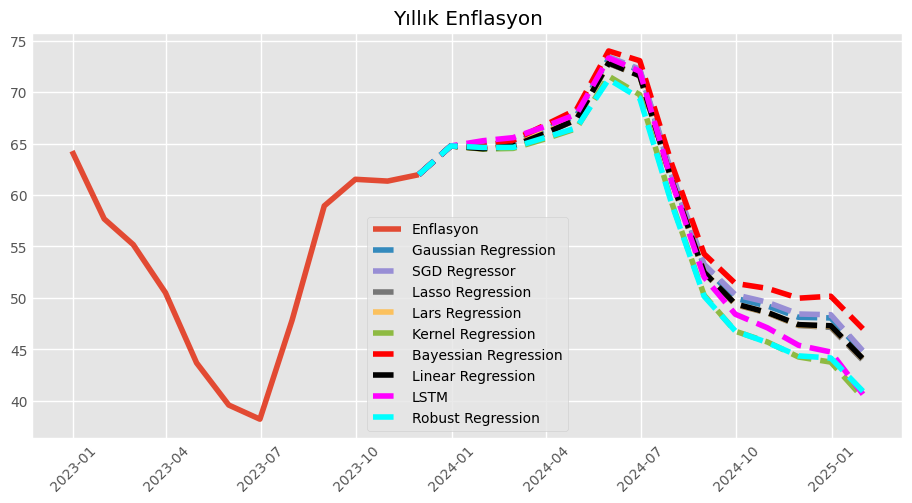

In [621]:
yıllıktahmin=pd.DataFrame()
yıllıktahmin["Ortalama"]=tüfetahmin11["CPI"]
yıllıktahmin["SGD Regressor"]=tüfetahmin13["CPI"]
yıllıktahmin["Gaussian Regression"]=tüfetahmin12["CPI"]
yıllıktahmin["Lasso Regression"]=tüfetahmin14["CPI"]
yıllıktahmin["Lars Regression"]=tüfetahmin15["CPI"]
yıllıktahmin["Kernel Regression"]=tüfetahmin16["CPI"]
yıllıktahmin["Bayessian Regression"]=tüfetahmin17["CPI"]
yıllıktahmin["Linear Regression"]=tüfetahmin18["CPI"]
yıllıktahmin["Linear Regression"]=tüfetahmin18["CPI"]
yıllıktahmin["LSTM"]=tüfetahmin20["CPI"]
yıllıktahmin["Robust Regression"]=tüfetahmin22["CPI"]
plt.figure(figsize=(10,5))
plt.plot(yıllıktahmin["Ortalama"].iloc[12:24],label="Enflasyon")
plt.plot(yıllıktahmin["Gaussian Regression"].iloc[23:],'--',label="Gaussian Regression")
plt.plot(yıllıktahmin["SGD Regressor"].iloc[23:],'--',label="SGD Regressor")
plt.plot(yıllıktahmin["Lasso Regression"].iloc[23:],'--',label="Lasso Regression")
plt.plot(yıllıktahmin["Lars Regression"].iloc[23:],'--',label="Lars Regression")
plt.plot(yıllıktahmin["Kernel Regression"].iloc[23:],'--',label="Kernel Regression")
plt.plot(yıllıktahmin["Bayessian Regression"].iloc[23:],'--',label="Bayessian Regression",color="red")
plt.plot(yıllıktahmin["Linear Regression"].iloc[23:],'--',label="Linear Regression",color="black")
plt.plot(yıllıktahmin["LSTM"].iloc[23:],'--',label="LSTM",color="magenta")
plt.plot(yıllıktahmin["Robust Regression"].iloc[23:],'--',label="Robust Regression",color="cyan")
plt.legend(loc=0)
plt.xticks(rotation=45)
#plt.xticks(pd.date_range(start="2022-12-30",end="2025-01-27",freq="1M")[::2])
plt.title("Yıllık Enflasyon")
plt.show()

In [622]:
yıllıktahmin["Maksimum"]=tüfetahmin23["CPI"]
yıllıktahmin["Minimum"]=tüfetahmin24["CPI"]
yıllıktahmin

,Ortalama,SGD Regressor,Gaussian Regression,Lasso Regression,Lars Regression,Kernel Regression,Bayessian Regression,Linear Regression,LSTM,Robust Regression,Maksimum,Minimum
2021-12-31,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902
2022-01-31,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824
2022-02-28,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567
2022-03-31,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538
2022-04-30,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070
2022-05-31,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950
2022-06-30,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397
2022-07-31,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053
2022-08-31,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594
2022-09-30,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494


In [623]:
yıllıktahmin["Ortalama"]=yıllıktahmin.iloc[:,1:-2].mean(axis=1)
yıllıktahmin.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/yıllıktahmin.csv')
yıllıktahmin


,Ortalama,SGD Regressor,Gaussian Regression,Lasso Regression,Lars Regression,Kernel Regression,Bayessian Regression,Linear Regression,LSTM,Robust Regression,Maksimum,Minimum
2021-12-31,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902
2022-01-31,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824
2022-02-28,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567
2022-03-31,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538
2022-04-30,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070
2022-05-31,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950
2022-06-30,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397
2022-07-31,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053
2022-08-31,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594
2022-09-30,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494


In [624]:
sonu2023=str(yıllıktahmin.iloc[24,0])[:5]
tepe=str(yıllıktahmin.iloc[29,0])[:5]
sonu2024=str(yıllıktahmin.iloc[36,0])[:5]
max=str(yıllıktahmin.iloc[-2,-3])[:5]
min=str(yıllıktahmin.iloc[-2,-2])[:5]


In [625]:
min1=str(yıllıktahmin.iloc[36,-1])[:2]
max1=str(yıllıktahmin.iloc[36,-2])[:2]

In [626]:
min1

'39'

In [627]:
cariay=evds.get_data(["TP.PKAUO.S01.A.U"],startdate="01-11-2022",enddate="31-01-2024")
cariay=cariay.set_index(pd.date_range(start="2022-11-30",periods=15,freq="1M"))
del cariay["Tarih"]
cariay.columns=["Cari Ay Medyan Tahmin"]
cariay["TÜFE"]=df.iloc[-14:,0].shift(1).dropna()
cariay["Cari Ay Medyan Tahmin"]=1+(cariay["Cari Ay Medyan Tahmin"]/100)
cariay.iloc[-1,1]=1859.38
cariay["Enflasyon"]=cariay["Cari Ay Medyan Tahmin"]*cariay["TÜFE"]
cariay["TÜFE Önceki"]=df.iloc[-25:,0].shift(12).dropna()
cariay.iloc[-1,3]=1203.48
cariay["Enflasyon"]=((cariay["Enflasyon"]/cariay["TÜFE Önceki"])-1)*100
cariay

,Cari Ay Medyan Tahmin,TÜFE,Enflasyon,TÜFE Önceki
2022-11-30,1.0314,NaN,NaN,NaN
2022-12-31,1.0269,1115.26,66.716718,686.95
2023-01-31,1.0265,1128.45,51.769968,763.23
2023-02-28,1.0301,1203.48,54.976654,799.93
2023-03-31,1.0288,1241.33,51.377401,843.64
2023-04-30,1.0265,1269.75,44.055347,904.79
2023-05-31,1.0241,1300.04,42.887757,931.76
2023-06-30,1.0281,1300.60,36.736564,977.90
2023-07-31,1.0376,1351.59,40.096679,1001.03
2023-08-31,1.0554,1479.84,53.775724,1015.65


In [628]:
ay1sonra=evds.get_data(["TP.PKAUO.S01.B.U"],startdate="01-01-2024",enddate="31-01-2024")
ay1sonra["TÜFE"]=1959.97
ay1sonra["TÜFE Yeni"]=(1+(ay1sonra["TP_PKAUO_S01_B_U"]/100))*ay1sonra["TÜFE"]
ay1sonra["TÜFE Eski"]=df.loc["2023-02-28"]["CPI"]
ay1sonra["Enflasyon"]=((ay1sonra["TÜFE Yeni"]/ay1sonra["TÜFE Eski"])-1)*100
ay1sonra

,Tarih,TP_PKAUO_S01_B_U,TÜFE,TÜFE Yeni,TÜFE Eski,Enflasyon
0,2024-1,3.51,1959.97,2028.764947,1241.33,63.434779


In [629]:
ay2sonra=evds.get_data(["TP.BEK.S01.C.U"],startdate="01-01-2024",enddate="31-12-2024")
ay2sonra["TÜFE"]=2028.7649
ay2sonra["TÜFE Yeni"]=(1+(ay2sonra["TP_BEK_S01_C_U"]/100))*ay2sonra["TÜFE"]
ay2sonra["TÜFE Eski"]=df.loc["2023-03-31"]["CPI"]
ay2sonra["Enflasyon"]=((ay2sonra["TÜFE Yeni"]/ay2sonra["TÜFE Eski"])-1)*100
ay2sonra

,Tarih,TP_BEK_S01_C_U,TÜFE,TÜFE Yeni,TÜFE Eski,Enflasyon
0,2024-1,3.1,2028.7649,2091.656612,1269.75,64.729798


In [630]:
ay12sonra=evds.get_data(["TP.PKAUO.S01.D.U"],startdate="01-01-2024",enddate="31-12-2024")
ay12sonra.columns=["Tarih","12 Ay Sonrası"]
ay12sonra

,Tarih,12 Ay Sonrası
0,2024-1,42.04


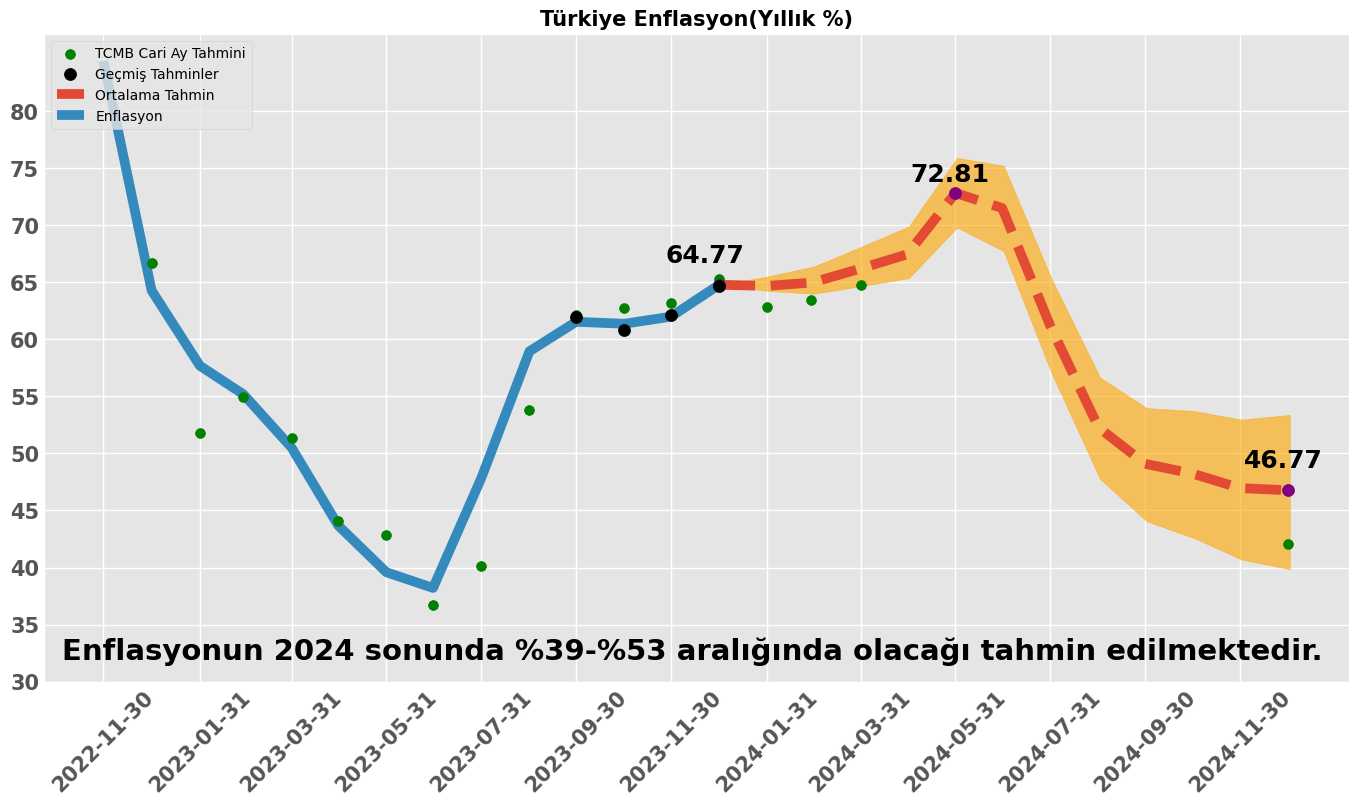

In [631]:
import matplotlib.dates as mdates  # datetime işlevlerini içe aktarın

# ...

plt.style.use('ggplot')
fig=plt.figure(figsize=(15,8))
plt.scatter(x=pd.to_datetime("2024-02-28"),y=ay1sonra["Enflasyon"],color="green",zorder=3,s=50)
plt.scatter(x=pd.to_datetime("2024-03-31"),y=ay2sonra["Enflasyon"],color="green",zorder=3,s=50)
plt.scatter(x=cariay[1:].index,y=cariay["Enflasyon"][1:].values,color="green",zorder=3,label='TCMB Cari Ay Tahmini',s=50)
plt.scatter(x=pd.to_datetime("2024-12-31"),y=ay12sonra["12 Ay Sonrası"].values,color="green",zorder=3,s=50)
plt.scatter(x=yıllıktahmin.index[21:25],y=[61.94,60.84,62.13,64.71],color='black',zorder=4,label='Geçmiş Tahminler',s=75)
plt.scatter(x=yıllıktahmin.index[24],y=yıllıktahmin.iloc[24,0],color='purple',zorder=3,s=75)
plt.scatter(x=yıllıktahmin.index[29],y=yıllıktahmin.iloc[29,0],color='purple',zorder=3,s=75)
plt.scatter(x=yıllıktahmin.index[36],y=yıllıktahmin.iloc[36,0],color='purple',zorder=3,s=75)
#plt.scatter(x=yıllıktahmin.index[36],y=yıllıktahmin.iloc[36,0],color='orange',zorder=3,s=50)
#plt.scatter(x=yıllıktahmin.index[36],y=yıllıktahmin.iloc[36,0],color='orange',zorder=3,s=50)
plt.plot(yıllıktahmin["Ortalama"].iloc[24:-1],'--',label="Ortalama Tahmin",linewidth=7)
plt.plot(yıllıktahmin["Ortalama"].iloc[11:25],label="Enflasyon",linewidth=7)
plt.fill_between(yıllıktahmin.iloc[24:].index.strftime("%Y-%m"), yıllıktahmin["Maksimum"].iloc[24:].shift(1), yıllıktahmin["Minimum"].iloc[24:].shift(1), alpha=0.6, color='orange')
# Tarihi ekseni birimlerine dönüştürün
annotation_date = mdates.datestr2num('2025-01')
plt.text(mdates.datestr2num('2023-12'), float(sonu2023)+2, sonu2023, fontsize=18, color='black', horizontalalignment='center',fontweight='bold')
plt.text(mdates.datestr2num('2024-06'), float(tepe)+1, tepe, fontsize=18, color='black', horizontalalignment='right',fontweight='bold')
plt.text(mdates.datestr2num('2025-01'), float(sonu2024)+2, sonu2024, fontsize=18, color='black', horizontalalignment='right',fontweight='bold')
#plt.text(mdates.datestr2num('2026-01'), float(sonu2024)-5, sonu2025, fontsize=18, color='black', horizontalalignment='right',fontweight='bold')
#plt.text(mdates.datestr2num('2025-12'), float(sonra24ay)+3, sonra24ay, fontsize=12, color='black', horizontalalignment='right',fontweight='bold')
plt.text(annotation_date, 32, f"Enflasyonun 2024 sonunda %{min1}-%{max1} aralığında olacağı tahmin edilmektedir.", fontsize=21, color='black', horizontalalignment='right',fontweight='bold')
plt.xticks(yıllıktahmin.index[11:37:2],rotation=45,fontsize=15,fontweight="bold")
plt.yticks(np.arange(30,85,5),fontsize=15,fontweight="bold")
plt.title("Türkiye Enflasyon(Yıllık %)",fontsize=15,fontweight="bold")
plt.legend(loc=2)
plt.savefig('forecast.png')
plt.savefig("./forecasts/"+date.today().strftime("%d-%m-%Y")+'.png')
plt.show()


(array([0, 1, 2, 3]),
 [Text(0, 0, '2023-09'),
  Text(1, 0, '2023-10'),
  Text(2, 0, '2023-11'),
  Text(3, 0, '2023-12')])

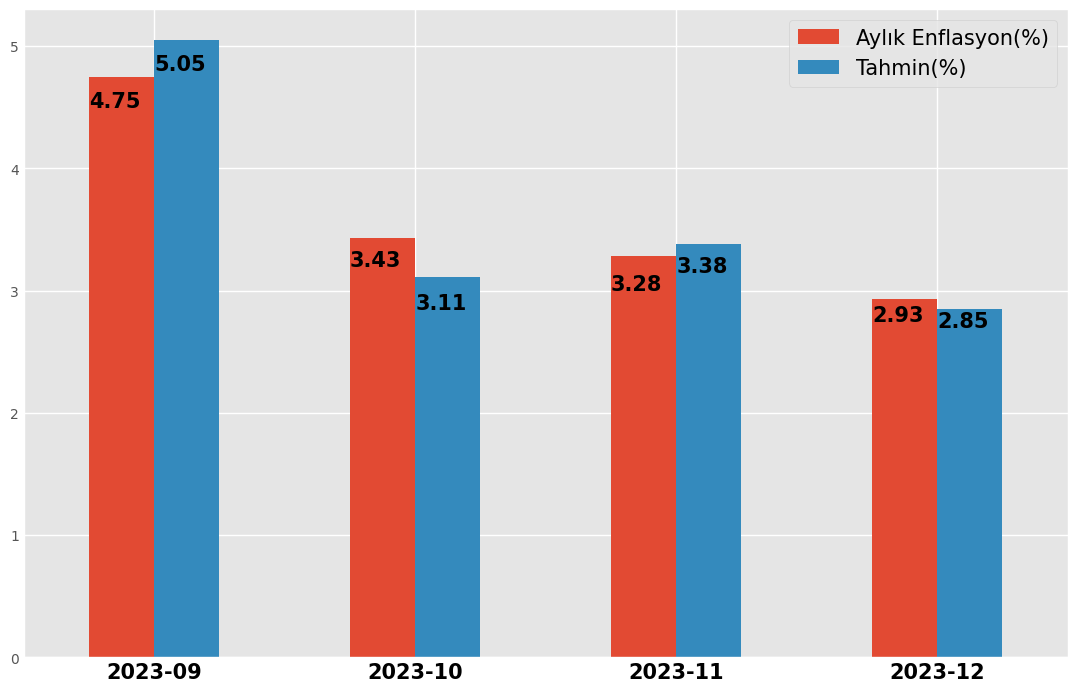

In [632]:
import matplotlib.axes as ax
gecmis=pd.DataFrame({"Aylık Enflasyon(%)":[4.75,3.43,3.28,2.93],"Tahmin(%)":[5.05,3.11,3.38,2.85]})
gecmis=gecmis.set_index(pd.date_range(start="2023-09-30",periods=4,freq="M"))
gecmis=gecmis.set_index(gecmis.index.strftime("%Y-%m"))
gecmis.plot(kind="bar",figsize=(12,8))
plt.annotate("4.75",xy=(-0.25,4.5),fontweight="bold",fontsize=15)
plt.annotate("5.05",xy=(0,4.8),fontweight="bold",fontsize=15)
plt.annotate("3.43",xy=(0.75,3.2),fontweight="bold",fontsize=15)
plt.annotate("3.11",xy=(1,2.85),fontweight="bold",fontsize=15)
plt.annotate("3.28",xy=(1.75,3),fontweight="bold",fontsize=15)
plt.annotate("3.38",xy=(2,3.15),fontweight="bold",fontsize=15)
plt.annotate("2.93",xy=(2.75,2.75),fontweight="bold",fontsize=15)
plt.annotate("2.85",xy=(3,2.7),fontweight="bold",fontsize=15)

plt.legend(fontsize=15)
plt.xticks(rotation=0,fontweight="bold",fontsize=15,color="black")

In [633]:
aralık=aylıktahmin.iloc[0,-1]
aralık = "{:.2f}".format(aralık)
sonu2023=yıllıktahmin.loc["2023-12-31","Ortalama"]
sonu2023="{:.2f}".format(sonu2023)
sonu2024=yıllıktahmin.loc["2024-12-31","Ortalama"]
sonu2024="{:.2f}".format(sonu2024)


In [634]:
aylıktahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,LSTM,Robust Regression,Ortalama,Maksimum,Minimum
2024-01-31,6.692463,6.474937,6.476545,6.461766,6.452384,6.551610,6.608840,6.979068,6.555291,6.583656,7.131774,6.299678
2024-02-29,3.426021,3.306553,3.311255,3.366427,3.186557,3.415174,3.525668,3.329895,3.148385,3.335142,3.678373,2.995680
2024-03-31,3.149127,3.060236,3.061865,3.094010,2.866081,3.102167,3.218233,2.968182,2.886414,3.045260,3.370938,2.713376
2024-04-30,3.228166,3.219031,3.190368,3.177495,3.001968,3.221418,3.295589,3.110925,2.966066,3.156994,3.448294,2.813361
2024-05-31,3.252641,3.319755,3.308085,3.291329,3.107466,3.343905,3.431922,3.299462,2.879153,3.248634,3.584627,2.726448
2024-06-30,3.198610,3.176590,3.218536,3.174861,2.826792,3.255284,3.356151,3.144573,2.802324,3.129006,3.508856,2.649618
2024-07-31,3.002693,2.942067,2.939112,2.931219,2.677406,2.969372,3.100440,2.624253,2.808875,2.888951,3.253145,2.471547
2024-08-31,3.180672,3.099351,3.064393,3.112346,2.969733,3.133237,3.272999,2.841238,2.972513,3.072453,3.425704,2.688533
2024-09-30,2.737362,2.651358,2.631524,2.611446,2.313027,2.631957,2.809111,2.277388,2.399397,2.563736,2.961817,2.124683
2024-10-31,2.930085,2.854298,2.864918,2.864839,2.693990,2.918399,3.101355,2.509148,2.641799,2.821228,3.254061,2.356443


Text(10.75, 2.6565253044800485, '2.79')

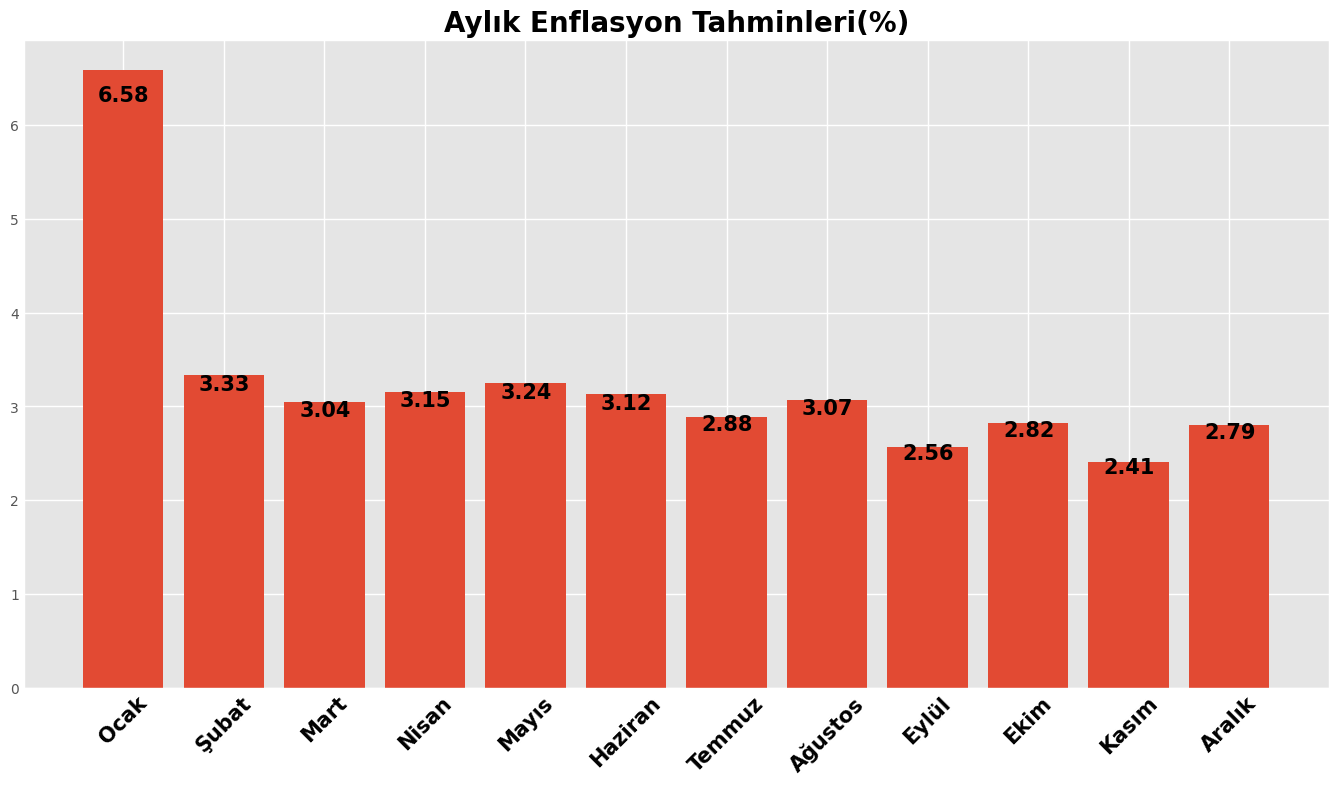

In [635]:
plt.figure(figsize=(15,8))
plt.bar(x=["Ocak","Şubat","Mart","Nisan","Mayıs","Haziran","Temmuz","Ağustos","Eylül","Ekim","Kasım","Aralık"],height=aylıktahmin.iloc[:-1,-3])
plt.xticks(rotation=45,fontweight="bold",color="black",fontsize=15)
plt.title("Aylık Enflasyon Tahminleri(%)",fontweight="bold",fontsize=20)
plt.annotate(str(aylıktahmin.iloc[0,-3])[:4],xy=(-0.25,aylıktahmin.iloc[0,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[1,-3])[:4],xy=(0.75,aylıktahmin.iloc[1,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[2,-3])[:4],xy=(1.75,aylıktahmin.iloc[2,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[3,-3])[:4],xy=(2.75,aylıktahmin.iloc[3,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[4,-3])[:4],xy=(3.75,aylıktahmin.iloc[4,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[5,-3])[:4],xy=(4.75,aylıktahmin.iloc[5,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[6,-3])[:4],xy=(5.75,aylıktahmin.iloc[6,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[7,-3])[:4],xy=(6.75,aylıktahmin.iloc[7,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[8,-3])[:4],xy=(7.75,aylıktahmin.iloc[8,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[9,-3])[:4],xy=(8.75,aylıktahmin.iloc[9,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[10,-3])[:4],xy=(9.75,aylıktahmin.iloc[10,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[11,-3])[:4],xy=(10.75,aylıktahmin.iloc[11,-3]*0.95),fontweight="bold",fontsize=15)